In [1]:
import os
import glob

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from collections import Counter

from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize

import datetime

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [3]:
from sklearn.naive_bayes import MultinomialNB

from sklearn import metrics

## define helper functions

In [4]:
# initialize 7 margins
margins = {'amount': 600,
          'authorization': 600,
          'date' : 600,
          'count' : 600,
          'intention' : 600,
          'utilization':600,
          'unknown':600}

In [5]:
def get_relevant_key_word_tokens(df_col, most_common = 10, inverse = False, least_common = 10):
    '''Takes a data frame and column name and returns a list of key word tokens. If inverse, then it will return the 10 least common tokens'''
    # make sure the column is strings
    for cell in df_col:
        assert(type(cell) == str)
    text_list = [t.lower() for t in df_col]
    text_string = ''
    for t in text_list:
        text_string = text_string + t + ' '
    text_tokens = [w for w in word_tokenize(text_string) if (w.isalnum() and w not in stopwords.words('english'))]
    if inverse:
        key_tokens = pd.DataFrame(Counter(text_tokens).most_common()).tail(10)
    else:
        key_tokens = pd.DataFrame(Counter(text_tokens).most_common(most_common))

    key_tokens.columns = ['key_tok', 'kt_count']
    
    return key_tokens


def define_nominated_paragraphs(filing, key_tokens, margin):
    '''takes an html filing, key_tokens, paragraph margin and returns nominated paragraphs'''
    
    # read in an html
    with open(filing) as file:
        file_html = file.read()
        
    # parse html
    parsed_html = BeautifulSoup(file_html, 'lxml')
    # filter out the html head, css, and cast to lower case
    string_filing = parsed_html.body.text.lower()
    
    ##################------- Predict Paragraphs ------##############################################
    #define candidate paragraphs by addin margins to each hit
    #
    #------ generate a list of token mathces / "hits"------------------------------
    #
    # collect the start and end indices of each token "hit." into an ugly list of lists of tuples
    lst_of_token_hits_lst = []
    for i in range(len(key_tokens.key_tok[0:10])):
        kt = key_tokens.key_tok[i]
        lst_of_token_hits_lst.append([(str(kt), m.start(), m.end()) for m in re.finditer(kt, string_filing)])
    #
    # flatten the ugly list of lists of tuples into a list of tuples
    flater_list_of_tokhits = [tpl for sublist in lst_of_token_hits_lst for tpl in sublist]
    #
    # order the list of token_hit tuples by starting index
    flater_list_of_tokhits.sort(key = lambda x: x[1])
    #
    #-------- use the token hits to define the bounds of the candidate paragraphs -------
    #
    # initialize a list of candidate paragraph bounds
    candidate_paragraphs = []
    
    for i in range(len(flater_list_of_tokhits)):
    #    
    #    # initialize the left and right bound of a paragraph
        leftbound = flater_list_of_tokhits[i][1] - margin
        rightbound = flater_list_of_tokhits[i][2] + margin
        
        # ensure bounds are not out of index range
        if leftbound < 0:
            leftbound = 0
        if rightbound > len(string_filing):
            rightbound = len(string_filing)

        par_bounds = (leftbound, rightbound) 
        candidate_paragraphs.append(par_bounds)
    
    return candidate_paragraphs, string_filing

In [6]:
def define_nominated_texts(par, key_tokens, margin):
    '''takes a paragraph, key_tokens, text margin and returns nominated texts'''
    
    ##################------- Predict texts ------##############################################
    #define candidate texts by adding margins to each hit
    #
    #------ generate a list of token mathces / "hits"------------------------------
    #
    # collect the start and end indices of each token "hit." into an ugly list of lists of tuples
    lst_of_token_hits_lst = []
    for i in range(len(key_tokens.key_tok[:])):
        kt = key_tokens.key_tok[i]
        if kt not in par:
            continue
        lst_of_token_hits_lst.append([(str(kt), m.start(), m.end()) for m in re.finditer(kt, par)])
    #
    # flatten the ugly list of lists of tuples into a list of tuples
    flater_list_of_tokhits = [tpl for sublist in lst_of_token_hits_lst for tpl in sublist]
    #
    # order the list of token_hit tuples by starting index
    flater_list_of_tokhits.sort(key = lambda x: x[1])
    #
    #-------- use the token hits to define the bounds of the candidate paragraphs -------
    #
    # initialize a list of candidate texts bounds
    candidate_texts = []
    
    for i in range(len(flater_list_of_tokhits)):
    #    
    #    # initialize the left and right bound of a paragraph
        leftbound = flater_list_of_tokhits[i][1] - margin
        rightbound = flater_list_of_tokhits[i][2] + margin
        
        # ensure bounds are not out of index range
        if leftbound < 0:
            leftbound = 0
        if rightbound > len(par):
            rightbound = len(par)

        par_bounds = (leftbound, rightbound) 
        candidate_texts.append(par_bounds)
    
    return candidate_texts, par

In [41]:
def measure_inclusion(predicted_par, test_par, verbose = False):
    '''takes two strings, eliminates excess spaces and new lines and stopwords, casts to lower, tokenizes and then compares inclusion'''
    # pre process paragraphs and generate tokens
    pred = re.sub(r'\n+', ' ', predicted_par)
    pred = re.sub(r'\s+', ' ', pred)
    pred = pred.lower()
    pred_tokens = [wt for wt in word_tokenize(pred) if (wt.isalnum() and wt not in stopwords.words('english'))]
    if len(pred) == 0:
        pred_tokens = [np.nan]
    
    test = re.sub(r'\n+', ' ', test_par)
    test = re.sub(r'\s+', ' ', test)
    test = test.lower()
    test_tokens = [wt for wt in word_tokenize(test) if (wt.isalnum() and wt not in stopwords.words('english'))]
    
    # calculate total inclusion
    total_inclusion = False
    if test in pred:
        total_inclusion = True
    # calculate test-inclusion percentage ()
    counter = 0
    for wt in test_tokens:
        if wt in pred_tokens:
            counter += 1
    if len(test_tokens) == 0:
        inclusion_pct = np.nan
    else:
        inclusion_pct = round(100*counter/len(test_tokens), 2)
    
    # calculate extra baggage percentage
    bag_counter = 0
    for wt in pred_tokens:
        if wt not in test_tokens:
            bag_counter += 1
    if len(pred_tokens) == 0:
        baggage_pct = np.nan
    else:
        baggage_pct = round(100*bag_counter/len(pred_tokens), 2)
    
    # package results for output
    results = {'total_inclusion' : total_inclusion,
              'inclusion_pct' : inclusion_pct,
              'baggage_pct': baggage_pct,
              'pred_tokenized_par_len': len(pred_tokens),
              'test_tokenized_par_len': len(test_tokens)}
    
    # reporting
    if verbose == True:
        print(results)
    
    return results
    

In [53]:
def report_inclusion(df):
    '''outputs printed and visualized report of inclusion rates'''
    # total inclusion rate
    print("For each test text, how many of them are 100% included in the predicted text?")
    print(round(100*(df.predtext_totinc.sum())/len(df.predtext_totinc), 2), '% total inclusion')
    print("-"*30)
    
    # report inclusion_rate
    print('For each test text, how much of it is included in the corresponding predicted text?')
    df.predtext_inclpct.plot(kind = 'hist', color = 'limegreen', alpha = 1)
    plt.title('Histogram of Inclusion Rates')
    plt.grid()
    plt.show()
    print('-- Mean inclusion rate', np.mean(df.predtext_inclpct))
    print('-- Median inclusion rate', df.predtext_inclpct.median())
    print("--------------------------")
    print("")

In [131]:
def get_model_paragraph(nom_pars, string_filing, model = 'token_density', key_tokens = None, vectorizer = None, verbose = False, inverse = False):
    '''takes a list of tuples of nominated paragraph bounds and a their corresponding document and returns one paragraph'''
    nominee = ''
    best_proba = 0.0
    for tpl in nom_pars:
        # generate par
        par = string_filing[tpl[0]:tpl[1]]
        # pre process par
        par = re.sub(r'\n+', ' ', par)
        par = re.sub(r'\s+', ' ', par)
        
        # if the naiver bayes prediction of classification as a given dkfn's class is new_best probability
        
        if model == 'token_density' and key_tokens.key_tok[0] in par and key_tokens.key_tok[1] in par and key_tokens.key_tok[2] in par:
            #assert key_tokens != None
            hits = 0
            w_tokens = [wt for wt in word_tokenize(par) if (wt.isalnum() and wt not in stopwords.words('english'))]
            if len(w_tokens) == 0:
                print(par)
            for wt in w_tokens:
                if wt in key_tokens.key_tok.values:
                    hits += 1
            #tk_density = hits/len(w_tokens)
            #if tk_density > best_proba:
            if hits > best_proba:
                best_proba = hits
                nominee = par
                #best_proba = tk_density
            
        elif model != 'token_density':
            #assert vectorizer != None
            # tfidf_vectorize the string into a sparse matrix
            par_vectorized = vectorizer.transform([par])
        
            # if using inverse we'll select the model's least favorite predictions
            # ------------------------------ prediction of being in the class == False -------------------------------- probability of it being false
            try:
                if inverse and model.predict(par_vectorized)[0] == 0 and model.predict_proba(par_vectorized)[0][0] > best_proba:
                    nominee = par
                    best_proba = model.predict_proba(par_vectorized)[0][0]
            
                # if not using inverse
                elif model.predict(par_vectorized)[0] == 1 and model.predict_proba(par_vectorized)[0][1] > best_proba:
                    #print(nb_auth_classifier.predict_proba(par_vectorized))
                    nominee = par
                    #print(nominee)
                    best_proba = model.predict_proba(par_vectorized)[0][1]
            except ValueError:
                print('Value error')
            finally:
                print('moving on')
            
        # write the results
        results_dct = {'nominee' : nominee,
                      'best_proba' : best_proba}
    
    if verbose:
        print('best probability', best_proba)
        print('-'*100)
        print(nominee)
        print('='*100)
    
    return results_dct

## read, my paragraph predictions csv

In [78]:
share_rprchs_prgrph_df = pd.read_csv('ml_predictions_validated.csv', index_col=0)

In [79]:
share_rprchs_prgrph_df.drop('Unnamed: 0.1', axis = 'columns', inplace=True)
share_rprchs_prgrph_df.head()

,ticker,accession_number,data_key_friendly_name,text,data_value,reported_data_value,reported_units,paragraph_text,pred_par,amount,...,count,intention,utilization,unknown,pred_proba,tknzd_tst_par_len,tot_incl,inclusion_pct,baggage_pct,tknzd_pred_par_len
0,A,0001090872-17-000018,Share Repurchase Authorization Date,"May 28, 2015",20150528,20200000.00,ones,"On May 28, 2015 we announced that our board ...","ases under this authorization. on may 28, 2015...",0,...,0,0,0,0,0.975636,46.0,False,97.83,40.00,['pred_tokenized_par_len']
1,A,0001090872-17-000018,Share Repurchase Authorization,The 2015 share repurchase program authorizes t...,1140000000,1.14,billions,"On May 28, 2015 we announced that our board ...","31, 2016 we repurchased approximately 2.4 mil...",0,...,0,0,0,0,0.988679,46.0,False,97.83,40.91,['pred_tokenized_par_len']
2,A,0001090872-17-000018,Share Repurchase Intention,remaining authorization to repurchase up to,610000000,610.00,millions,"Table of Contents 2016, upon the completion ...","zation. on may 28, 2015 we announced that our ...",0,...,0,1,0,0,0.999220,38.0,False,94.74,47.27,['pred_tokenized_par_len']
3,A,0001090872-17-000018,Share Repurchase Count,repurchased,4100000,4.10,millions,"Table of Contents 2016, upon the completion ...",ed the purchases under this authorization. on ...,0,...,1,0,0,0,0.994602,38.0,False,94.74,46.36,['pred_tokenized_par_len']
4,A,0001090872-17-000018,Amount Spent on Share Repurchases,repurchased,194000000,194.00,millions,"Table of Contents 2016, upon the completion ...",ed the purchases under this authorization. on ...,1,...,0,0,0,0,0.991570,38.0,False,94.74,46.36,['pred_tokenized_par_len']


In [11]:
share_rprchs_prgrph_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1772 entries, 0 to 1771
Data columns (total 22 columns):
ticker                    1772 non-null object
accession_number          1772 non-null object
data_key_friendly_name    1772 non-null object
text                      1772 non-null object
data_value                1772 non-null int64
reported_data_value       1772 non-null float64
reported_units            1772 non-null object
paragraph_text            1772 non-null object
pred_par                  1772 non-null object
amount                    1772 non-null int64
authorization             1772 non-null int64
date                      1772 non-null int64
count                     1772 non-null int64
intention                 1772 non-null int64
utilization               1772 non-null int64
unknown                   1772 non-null int64
pred_proba                1772 non-null float64
tknzd_tst_par_len         1772 non-null float64
tot_incl                  1772 non-null bool
inclusi

#### fix the'tknzd_pred_par_len' column

In [12]:
for i in range(len(share_rprchs_prgrph_df.pred_par)):
    pred = re.sub(r'\n+', ' ', share_rprchs_prgrph_df.pred_par[i])
    pred = re.sub(r'\s+', ' ', pred)
    pred = pred.lower()
    # get length of it 
    share_rprchs_prgrph_df.tknzd_pred_par_len[i] = len([wt for wt in word_tokenize(pred) if (wt.isalnum() and wt not in stopwords.words('english'))])
    #print('processed row', i, 'of', 1772, i/1772, '% done')

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [13]:
share_rprchs_prgrph_df.tknzd_pred_par_len[0:5]

0    110
1    110
2    110
3    110
4    110
Name: tknzd_pred_par_len, dtype: object

============================== Inclusion Report ==================================================
For each test paragraph, how many of them are 100% included in the predicted paragraph?
19.47 % total inclusion
------------------------------
For each test paragraph, how much of it is included in the corresponding predicted paragraph?


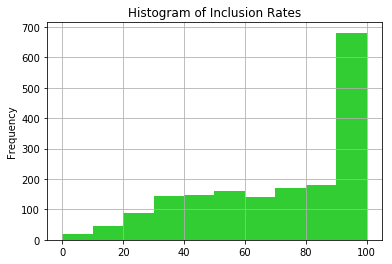

-- Mean inclusion rate 71.95947516930025
-- Median inclusion rate 78.18
--------------------------

For each predicted paragraph, how much of it is extra content not in the test paragraph?


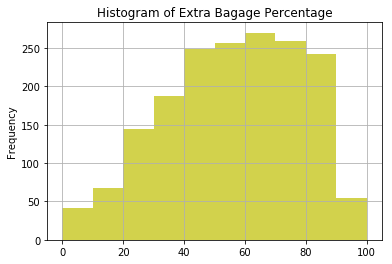

-- mean bagage rate:  56.12998306997744
-- median bagage rate:  57.82
----------------

What is the distribution of lengths of the word tokenized test paragraphs.


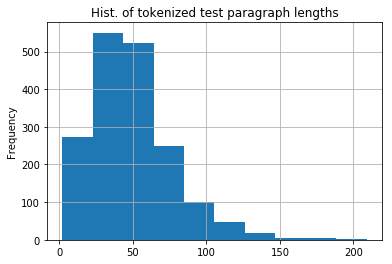

-- Mean tokenized test paragraph length  49.715011286681715
-- Median tokenized test paragraph length 46.0
-- Range of tokenized test paragraph lengths 207.0
------------------------------

What is the distribution of lengths of the word tokenized test paragraphs.


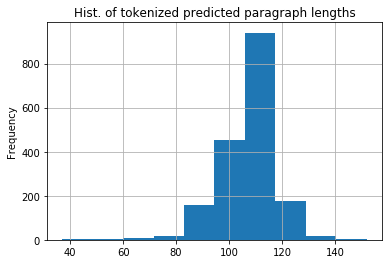

-- mean tokenized predicted parag. lenghts 107.33521444695259
-- median tokenized predicted parag. lenghts 108.0
-- range of tokenized predicted parag. lenghts 115
------------------------------



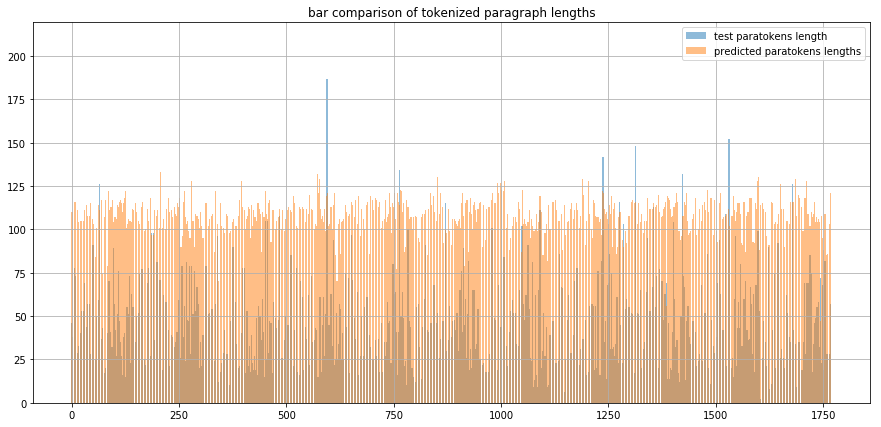

In [14]:
# report and plot the overall inclusion
print('='*30, 'Inclusion Report', '='*50)

# total inclusion rate
print("For each test paragraph, how many of them are 100% included in the predicted paragraph?")
print(round(100*(share_rprchs_prgrph_df.tot_incl.sum())/len(share_rprchs_prgrph_df.tot_incl), 2), '% total inclusion')
print("-"*30)

# report inclusion_rate
#plt.hist(share_rprchs_prgrph_df.inclusion_pct, bins=20)
print('For each test paragraph, how much of it is included in the corresponding predicted paragraph?')
share_rprchs_prgrph_df.inclusion_pct.plot(kind = 'hist', color = 'limegreen', alpha = 1)
plt.title('Histogram of Inclusion Rates')
plt.grid()
plt.show()
print('-- Mean inclusion rate', np.mean(share_rprchs_prgrph_df.inclusion_pct))
print('-- Median inclusion rate', share_rprchs_prgrph_df.inclusion_pct.median())
print("--------------------------")
print("")

# report extra baggage rate
#plt.hist(share_rprchs_prgrph_df.baggage_pct)
print('For each predicted paragraph, how much of it is extra content not in the test paragraph?')
share_rprchs_prgrph_df.baggage_pct.plot(kind = 'hist', color = 'y', alpha = .7)
plt.title('Histogram of Extra Bagage Percentage')
plt.grid()
plt.show()
print('-- mean bagage rate: ', np.mean(share_rprchs_prgrph_df.baggage_pct))
print('-- median bagage rate: ', share_rprchs_prgrph_df.baggage_pct.median())
print("----------------")
print("")

# report lengths of tokenized paragraphs
print("What is the distribution of lengths of the word tokenized test paragraphs.")
share_rprchs_prgrph_df.tknzd_tst_par_len.plot(kind = 'hist')
plt.title('Hist. of tokenized test paragraph lengths')
plt.grid()
plt.show()
print('-- Mean tokenized test paragraph length ', np.mean(share_rprchs_prgrph_df.tknzd_tst_par_len))
print('-- Median tokenized test paragraph length', share_rprchs_prgrph_df.tknzd_tst_par_len.median())
print('-- Range of tokenized test paragraph lengths', np.max(share_rprchs_prgrph_df.tknzd_tst_par_len) - np.min(share_rprchs_prgrph_df.tknzd_tst_par_len))
print("-"*30)
print("")

#plt.hist(share_rprchs_prgrph_df.tknzd_pred_par_len)
print("What is the distribution of lengths of the word tokenized test paragraphs.")
share_rprchs_prgrph_df.tknzd_pred_par_len.plot(kind = 'hist')
plt.title('Hist. of tokenized predicted paragraph lengths')
plt.grid()
plt.show()
print('-- mean tokenized predicted parag. lenghts', np.mean(share_rprchs_prgrph_df.tknzd_pred_par_len))
print('-- median tokenized predicted parag. lenghts', share_rprchs_prgrph_df.tknzd_pred_par_len.median())
print('-- range of tokenized predicted parag. lenghts', (np.max(share_rprchs_prgrph_df.tknzd_pred_par_len)) - np.min(share_rprchs_prgrph_df.tknzd_pred_par_len))
print("-"*30)
print("")
# plot overlay of each paragraph's lengths
plt.figure(figsize = (15,7))
plt.bar(height = share_rprchs_prgrph_df.tknzd_tst_par_len.fillna(np.nan), alpha = 0.5,
        x = range(len(share_rprchs_prgrph_df.paragraph_text)))
        #x = range(len(share_rprchs_prgrph_df.tknzd_tst_par_len.fillna(value = np.nan))))
plt.bar(height = share_rprchs_prgrph_df.tknzd_pred_par_len.fillna(np.nan), alpha = 0.5,
        x = range(len(share_rprchs_prgrph_df.paragraph_text)))
       #x = range(len(share_rprchs_prgrph_df.tknzd_pred_par_len.fillna(value = np.nan))))
plt.title('bar comparison of tokenized paragraph lengths')
plt.legend(['test paratokens length', 'predicted paratokens lengths'])
plt.grid()
plt.show()

### fit and train a df['text'] classification model for each dkfn

In [15]:
# split data into train, fit and test subsets
X_train, X_test, y_train_ix, y_test_ix = train_test_split(share_rprchs_prgrph_df.text,
                                                   share_rprchs_prgrph_df.index, ### Watchout this is just a placeholder for now
                                                   test_size = 0.33,
                                                   random_state = 53)
# initialize a TfidfVectorizer object
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df = 0.7)

In [16]:
# transform the training data
tfidf_train = tfidf_vectorizer.fit_transform(X_train)

# transform the test data
tfidf_test = tfidf_vectorizer.transform(X_test)

In [17]:
# make and fit a model for each dkfn
nb_amnt_classifier = MultinomialNB()
nb_amnt_classifier.fit(tfidf_train, 
                       share_rprchs_prgrph_df.amount[[ix in y_train_ix for ix in share_rprchs_prgrph_df.index]])
nb_auth_classifier = MultinomialNB()
nb_auth_classifier.fit(tfidf_train, 
                       share_rprchs_prgrph_df.authorization[[ix in y_train_ix for ix in share_rprchs_prgrph_df.index]])
nb_dt_classifier = MultinomialNB()
nb_dt_classifier.fit(tfidf_train, 
                       share_rprchs_prgrph_df.date[[ix in y_train_ix for ix in share_rprchs_prgrph_df.index]])
nb_cnt_classifier = MultinomialNB()
nb_cnt_classifier.fit(tfidf_train, 
                       share_rprchs_prgrph_df['count'][[ix in y_train_ix for ix in share_rprchs_prgrph_df.index]])
nb_intent_classifier = MultinomialNB()
nb_intent_classifier.fit(tfidf_train, 
                       share_rprchs_prgrph_df.intention[[ix in y_train_ix for ix in share_rprchs_prgrph_df.index]])
nb_util_classifier = MultinomialNB()
nb_util_classifier.fit(tfidf_train, 
                       share_rprchs_prgrph_df.utilization[[ix in y_train_ix for ix in share_rprchs_prgrph_df.index]])
nb_unk_classifier = MultinomialNB()
nb_unk_classifier.fit(tfidf_train, 
                       share_rprchs_prgrph_df.unknown[[ix in y_train_ix for ix in share_rprchs_prgrph_df.index]])


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

**Horizontally Validate the seven models**

In [18]:
models_lst = [nb_amnt_classifier, nb_auth_classifier, nb_cnt_classifier, nb_dt_classifier,
             nb_intent_classifier, nb_unk_classifier, nb_util_classifier]

for mod, col in zip(models_lst, ['amount', 'authorization', 'count' ,'date', 'intention', 'unknown', 'utilization']):
    pred = mod.predict(tfidf_test)
    score = metrics.accuracy_score(share_rprchs_prgrph_df[col][[ix in y_test_ix for ix in share_rprchs_prgrph_df.index]], pred)
    print(round(100*score, 1), '%', col, 'accuracy')

80.3 % amount accuracy
79.0 % authorization accuracy
84.6 % count accuracy
76.9 % date accuracy
86.3 % intention accuracy
93.2 % unknown accuracy
97.8 % utilization accuracy


### Define the dkfn slices
for each dkfn filter the data frame by that dkfn

In [19]:
unk_df = share_rprchs_prgrph_df[share_rprchs_prgrph_df.data_key_friendly_name == 'Unknown Share Repurchase Data']
#unk_df.info()

In [20]:
util_df = share_rprchs_prgrph_df[share_rprchs_prgrph_df.data_key_friendly_name == 'Share Repurchase Utilization']
#util_df.info()

In [21]:
shrp_intent_df = share_rprchs_prgrph_df[share_rprchs_prgrph_df.data_key_friendly_name == 'Share Repurchase Intention']
#shrp_intent_df.info()

In [22]:
shrp_count_df = share_rprchs_prgrph_df[share_rprchs_prgrph_df.data_key_friendly_name == 'Share Repurchase Count']
#shrp_count_df.info()

In [23]:
auth_dt_df = share_rprchs_prgrph_df[share_rprchs_prgrph_df.data_key_friendly_name == 'Share Repurchase Authorization Date']
#auth_dt_df.info()

In [24]:
auth_df = share_rprchs_prgrph_df[share_rprchs_prgrph_df.data_key_friendly_name == 'Share Repurchase Authorization']
#auth_df.info()

In [25]:
amnt_spnt_df = share_rprchs_prgrph_df[share_rprchs_prgrph_df.data_key_friendly_name == 'Amount Spent on Share Repurchases']
#amnt_spnt_df.info()

In [26]:
# spot check that the text column is only strings
for c in share_rprchs_prgrph_df.text:
    assert(type('str') == type(c))

In [27]:
dkfn_slices = [unk_df, util_df, shrp_count_df, shrp_intent_df, 
               auth_df, auth_dt_df, amnt_spnt_df]

In [28]:
type(dkfn_slices[0])

pandas.core.frame.DataFrame

## generate key_tokens for each dkfn
store key_tokens and models in dictionaries for later use

In [29]:
## use dictionary to assign models in loop
models_dict ={}
for mdl, k in zip(models_lst,
                 ['spent_model', 'auth_model', 'count_model', 'date_model', 
                  'intent_model', 'unk_model', 'util_model']):
    models_dict['{0}'.format(k)] = mdl


In [30]:
# use dictionary to assign variables in loop:
dkfn_kts_dict = {}
for slc, k in zip(dkfn_slices, 
                  ['unk_kts', 'util_kts', 'count_kts', 'intent_kts', 'auth_kts', 'date_kts', 'spent_kts']):
    dkfn_kts_dict['{0}'.format(k)] = get_relevant_key_word_tokens(slc.text)
    
#print(dkfn_kts_dict)

In [31]:
dkfn_kts_dict['unk_kts']

,key_tok,kt_count
0,repurchase,74
1,board,54
2,authorized,52
3,directors,49
4,program,31
5,shares,25
6,company,24
7,authorization,18
8,share,15
9,approved,12


### stage filings to be iteratively read in

In [39]:
# initialize a list of paths
training_filings_list = []

# populate the list
for root, dirs, files in os.walk('data/nc_training_filings/'):
    training_filings_list += glob.glob(os.path.join(root, '*.html'))
#print(training_filings_list[0:3])

In [71]:
len(training_filings_list)

435

In [76]:
round(160/len(training_filings_list),2)*100

37.0

### stage test filings

In [69]:
# initialize a list of paths
validation_filings_list = []

# populate the list
for root, dirs, files in os.walk('data/nc_validation_filings/'):
    validation_filings_list += glob.glob(os.path.join(root, '*.html'))
print(training_filings_list[0:3])

['data/nc_training_filings/0001193125-17-248016.html', 'data/nc_training_filings/0000318154-18-000004.html', 'data/nc_training_filings/0000769397-18-000011.html']


# fit and train the models on the entire training set

# transform entire data set for validation csv output
tfidf_train = tfidf_vectorizer.fit_transform(share_rprchs_prgrph_df.text)
# fit models to entire daata set for validation csv output
nb_amnt_classifier = MultinomialNB()
nb_amnt_classifier.fit(tfidf_train, 
                       share_rprchs_prgrph_df.amount)
nb_auth_classifier = MultinomialNB()
nb_auth_classifier.fit(tfidf_train, 
                       share_rprchs_prgrph_df.authorization)
nb_dt_classifier = MultinomialNB()
nb_dt_classifier.fit(tfidf_train, 
                       share_rprchs_prgrph_df.date)
nb_cnt_classifier = MultinomialNB()
nb_cnt_classifier.fit(tfidf_train, 
                       share_rprchs_prgrph_df['count'])
nb_intent_classifier = MultinomialNB()
nb_intent_classifier.fit(tfidf_train, 
                       share_rprchs_prgrph_df.intention)
nb_util_classifier = MultinomialNB()
nb_util_classifier.fit(tfidf_train, 
                       share_rprchs_prgrph_df.utilization)
nb_unk_classifier = MultinomialNB()
nb_unk_classifier.fit(tfidf_train, 
                       share_rprchs_prgrph_df.unknown)

# check their would-be-validation
models_lst = [nb_amnt_classifier, nb_auth_classifier, nb_cnt_classifier, nb_dt_classifier,
             nb_intent_classifier, nb_unk_classifier, nb_util_classifier]

for mod, col in zip(models_lst, ['amount', 'authorization', 'count' ,'date', 'intention', 'unknown', 'utilization']):
    pred = mod.predict(tfidf_train)
    score = metrics.accuracy_score(share_rprchs_prgrph_df[col], pred)
    print(round(100*score, 1), '%', col, 'accuracy')

## read in and preprocess validation dataframe

dkfns_for_validation = ['Share Repurchase Intention',
 'Share Repurchase Utilization',
 'Amount Spent on Share Repurchases',
 'Share Repurchase Count',
 'Share Repurchase Authorization Date',
 'Unknown Share Repurchase Data',
 'Share Repurchase Authorization']

share_rprchs_prgrph_df = pd.read_csv('data/nc_validation_filings (1).csv')
share_rprchs_prgrph_df = pd.concat([share_rprchs_prgrph_df]*7, ignore_index=True)
share_rprchs_prgrph_df.sort_values('accession_number', inplace = True)
share_rprchs_prgrph_df.reset_index(inplace=True, drop = True)
share_rprchs_prgrph_df['data_key_friendly_name'] = dkfns_for_validation*100
share_rprchs_prgrph_df['pred_par'] = None
share_rprchs_prgrph_df['pred_proba'] = None
share_rprchs_prgrph_df.head()

share_rprchs_prgrph_df.data_key_friendly_name.value_counts()

# For each filing
## predict and vertically validate paragraph
Compare the predicted paragraph column to the test paragraph column
- don't run this again unless you want to wait about 2 hours to output anew the csv I previously wrote out and have now read in at the top this notebook

In [111]:
#for i in range(len(training_filings_list)):
for i in range(len(validation_filings_list)):
    #filing = training_filings_list[i]
    filing = validation_filings_list[i]
    ti = datetime.datetime.now()
    print(ti, 'WORKING ON FILING', i, 'out of', len(validation_filings_list), 100*i/len(validation_filings_list), '% done.')
    #print(ti, 'WORKING ON FILING', i, 'out of', len(training_filings_list), 100*i/len(training_filings_list), '% done.')
    # filter down to that filings dataframe rows
    # extract the accesion number back out of the filing path
    an = re.sub('data/nc_validation_filings/', '', filing)
    an = re.sub('.html', '', an)
    
    # for each dkfn_row in df_slice
    for i in share_rprchs_prgrph_df.data_key_friendly_name[share_rprchs_prgrph_df.accession_number == an].index:
        to = datetime.datetime.now()
        print(to, '-- working on', share_rprchs_prgrph_df.ticker[i], share_rprchs_prgrph_df.data_key_friendly_name[i])
        
        # If there is already a prediction move on to the next row
        if share_rprchs_prgrph_df.pred_proba[i] != None:
            print("---- already made a prediction for", share_rprchs_prgrph_df.ticker[i], share_rprchs_prgrph_df.data_key_friendly_name[i])
            continue
        
        # select appropriate dkfn key_tokens
        for k in dkfn_kts_dict.keys():
            # trim the name of the key
            trimmed_key = re.sub('_kts', '', k)
            # check to see if it is in the dkfn column.lower()
            if trimmed_key in share_rprchs_prgrph_df.data_key_friendly_name[i].lower():
                # for authorization, distinguish between generic auth and auth_date
                if trimmed_key == 'auth' and 'date' in share_rprchs_prgrph_df.data_key_friendly_name[i].lower():
                    continue
                # if so, then assign that kts df
                key_tokens = dkfn_kts_dict[k]
                print(datetime.datetime.now(), '------ using key_tokens for', k)
        
        #predict a pragraph using that rows dkfn's margin and key toks
        nominees, string_filing = define_nominated_paragraphs(filing, key_tokens = key_tokens, margin = 600)
        
        # select appropriate model for dkfn
        for k in models_dict.keys():
            # trim the name of the key
            trimmed_key = re.sub('_model', '', k)
            # check to see if it is in the dkfn column.lower()
            if trimmed_key in share_rprchs_prgrph_df.data_key_friendly_name[i].lower():
                # for authorization, distinguish between generic auth and auth_date
                if trimmed_key == 'auth' and 'date' in share_rprchs_prgrph_df.data_key_friendly_name[i].lower():
                    continue
                # if so, then assign that kts df
                model = models_dict[k]
                print(datetime.datetime.now(), '------ using', k)
        
        #pred_par = par_with_highest_kt_hit_density or par_with_models_highest_pred_proba
        pred_dct = get_model_paragraph(nominees, string_filing, model = 'token_density', key_tokens=key_tokens, verbose = False, inverse= False)
        pred_par = pred_dct['nominee']
        
        # write the paragraph to the df
        share_rprchs_prgrph_df.pred_par[i] = pred_par
        share_rprchs_prgrph_df.pred_proba[i] = pred_dct['best_proba']
        print(datetime.datetime.now(), '---------- wrote predicted paragraph. row took', datetime.datetime.now() - ti)
        #print('wrote', pred_par)
        
        '''# score the inclusion
        results_dct = measure_inclusion(pred_par, share_rprchs_prgrph_df.paragraph_text[i], verbose = False)
        print(datetime.datetime.now(), "measured inclusion.")
        print("="*75)
        # store the inclusion data
        share_rprchs_prgrph_df.tot_incl[i] = (results_dct['total_inclusion'])
        share_rprchs_prgrph_df.inclusion_pct[i] = (results_dct['inclusion_pct'])
        share_rprchs_prgrph_df.baggage_pct[i] = (results_dct['baggage_pct'])
        share_rprchs_prgrph_df.tknzd_tst_par_len[i] = (results_dct['test_tokenized_par_len'])
        share_rprchs_prgrph_df.tknzd_pred_par_len[i] = (results_dct['pred_tokenized_par_len'])'''
        

2018-06-09 20:00:14.075907 WORKING ON FILING 0 out of 100 0.0 % done.
2018-06-09 20:00:14.078468 -- working on AWI Share Repurchase Intention
2018-06-09 20:00:14.079102 ------ using key_tokens for intent_kts
2018-06-09 20:00:17.629214 ------ using intent_model
2018-06-09 20:00:21.669364 ---------- wrote predicted paragraph. row took 0:00:07.593462
2018-06-09 20:00:21.670186 -- working on AWI Share Repurchase Utilization
2018-06-09 20:00:21.670661 ------ using key_tokens for util_kts
2018-06-09 20:00:25.123762 ------ using util_model
2018-06-09 20:00:26.423305 ---------- wrote predicted paragraph. row took 0:00:12.347404
2018-06-09 20:00:26.423509 -- working on AWI Amount Spent on Share Repurchases
2018-06-09 20:00:26.423901 ------ using key_tokens for spent_kts
2018-06-09 20:00:29.672257 ------ using spent_model
2018-06-09 20:00:30.801421 ---------- wrote predicted paragraph. row took 0:00:16.725520
2018-06-09 20:00:30.801564 -- working on AWI Share Repurchase Count
2018-06-09 20:00:30

2018-06-09 20:01:43.405008 ------ using intent_model
2018-06-09 20:01:45.482375 ---------- wrote predicted paragraph. row took 0:00:02.871263
2018-06-09 20:01:45.482544 -- working on DKS Share Repurchase Utilization
2018-06-09 20:01:45.482731 ------ using key_tokens for util_kts
2018-06-09 20:01:46.195519 ------ using util_model
2018-06-09 20:01:46.681545 ---------- wrote predicted paragraph. row took 0:00:04.070434
2018-06-09 20:01:46.681726 -- working on DKS Amount Spent on Share Repurchases
2018-06-09 20:01:46.682104 ------ using key_tokens for spent_kts
2018-06-09 20:01:47.558189 ------ using spent_model
2018-06-09 20:01:47.806499 ---------- wrote predicted paragraph. row took 0:00:05.195393
2018-06-09 20:01:47.806603 -- working on DKS Share Repurchase Count
2018-06-09 20:01:47.806789 ------ using key_tokens for count_kts
2018-06-09 20:01:48.713742 ------ using count_model
2018-06-09 20:01:51.485307 ---------- wrote predicted paragraph. row took 0:00:08.874195
2018-06-09 20:01:51.4

2018-06-09 20:03:14.470992 ------ using util_model
2018-06-09 20:03:14.675872 ---------- wrote predicted paragraph. row took 0:00:04.149005
2018-06-09 20:03:14.676007 -- working on CIM Amount Spent on Share Repurchases
2018-06-09 20:03:14.676320 ------ using key_tokens for spent_kts
2018-06-09 20:03:15.751296 ------ using spent_model
2018-06-09 20:03:15.904027 ---------- wrote predicted paragraph. row took 0:00:05.377159
2018-06-09 20:03:15.904168 -- working on CIM Share Repurchase Count
2018-06-09 20:03:15.904470 ------ using key_tokens for count_kts
2018-06-09 20:03:16.893738 ------ using count_model
2018-06-09 20:03:17.035743 ---------- wrote predicted paragraph. row took 0:00:06.508876
2018-06-09 20:03:17.035874 -- working on CIM Share Repurchase Authorization Date
2018-06-09 20:03:17.036194 ------ using key_tokens for date_kts
2018-06-09 20:03:18.014509 ------ using date_model
2018-06-09 20:03:20.783531 ---------- wrote predicted paragraph. row took 0:00:10.256664
2018-06-09 20:03

2018-06-09 20:04:42.433316 ------ using spent_model
2018-06-09 20:04:43.612768 ---------- wrote predicted paragraph. row took 0:00:06.542632
2018-06-09 20:04:43.612902 -- working on SAVE Share Repurchase Count
2018-06-09 20:04:43.613126 ------ using key_tokens for count_kts
2018-06-09 20:04:44.582763 ------ using count_model
2018-06-09 20:04:50.810228 ---------- wrote predicted paragraph. row took 0:00:13.740092
2018-06-09 20:04:50.810375 -- working on SAVE Share Repurchase Authorization Date
2018-06-09 20:04:50.810669 ------ using key_tokens for date_kts
2018-06-09 20:04:51.734111 ------ using date_model
2018-06-09 20:04:58.678190 ---------- wrote predicted paragraph. row took 0:00:21.608052
2018-06-09 20:04:58.678327 -- working on SAVE Unknown Share Repurchase Data
2018-06-09 20:04:58.678608 ------ using key_tokens for unk_kts
2018-06-09 20:04:59.679343 ------ using unk_model
2018-06-09 20:05:01.663573 ---------- wrote predicted paragraph. row took 0:00:24.593437
2018-06-09 20:05:01.

2018-06-09 20:06:31.108249 ------ using count_model
2018-06-09 20:06:31.170669 ---------- wrote predicted paragraph. row took 0:00:02.772766
2018-06-09 20:06:31.170796 -- working on DO Share Repurchase Authorization Date
2018-06-09 20:06:31.171098 ------ using key_tokens for date_kts
2018-06-09 20:06:31.705295 ------ using date_model
2018-06-09 20:06:36.160205 ---------- wrote predicted paragraph. row took 0:00:07.762305
2018-06-09 20:06:36.160339 -- working on DO Unknown Share Repurchase Data
2018-06-09 20:06:36.160567 ------ using key_tokens for unk_kts
2018-06-09 20:06:36.823589 ------ using unk_model
2018-06-09 20:06:36.853542 ---------- wrote predicted paragraph. row took 0:00:08.455641
2018-06-09 20:06:36.853698 -- working on DO Share Repurchase Authorization
2018-06-09 20:06:36.854005 ------ using key_tokens for auth_kts
2018-06-09 20:06:37.514893 ------ using auth_model
2018-06-09 20:06:37.563326 ---------- wrote predicted paragraph. row took 0:00:09.165426
2018-06-09 20:06:37.

2018-06-09 20:07:56.549249 ------ using date_model
2018-06-09 20:08:00.989117 ---------- wrote predicted paragraph. row took 0:00:20.002567
2018-06-09 20:08:00.989250 -- working on DDR Unknown Share Repurchase Data
2018-06-09 20:08:00.989495 ------ using key_tokens for unk_kts
2018-06-09 20:08:03.469800 ------ using unk_model
2018-06-09 20:08:05.128120 ---------- wrote predicted paragraph. row took 0:00:24.141569
2018-06-09 20:08:05.128255 -- working on DDR Share Repurchase Authorization
2018-06-09 20:08:05.128523 ------ using key_tokens for auth_kts
2018-06-09 20:08:08.194959 ------ using auth_model
2018-06-09 20:08:09.351926 ---------- wrote predicted paragraph. row took 0:00:28.365375
2018-06-09 20:08:09.352062 WORKING ON FILING 21 out of 100 21.0 % done.
2018-06-09 20:08:09.353392 -- working on TPX Share Repurchase Intention
2018-06-09 20:08:09.353706 ------ using key_tokens for intent_kts
2018-06-09 20:08:10.797412 ------ using intent_model
2018-06-09 20:08:15.194601 ---------- wr

2018-06-09 20:09:51.122235 ------ using unk_model
2018-06-09 20:09:53.497283 ---------- wrote predicted paragraph. row took 0:00:29.531626
2018-06-09 20:09:53.497453 -- working on AHL Share Repurchase Authorization
2018-06-09 20:09:53.497806 ------ using key_tokens for auth_kts
2018-06-09 20:09:56.470269 ------ using auth_model
2018-06-09 20:09:57.953834 ---------- wrote predicted paragraph. row took 0:00:33.988176
2018-06-09 20:09:57.953982 WORKING ON FILING 25 out of 100 25.0 % done.
2018-06-09 20:09:57.955311 -- working on TWO Share Repurchase Intention
2018-06-09 20:09:57.955609 ------ using key_tokens for intent_kts
2018-06-09 20:09:59.814330 ------ using intent_model
2018-06-09 20:10:03.300239 ---------- wrote predicted paragraph. row took 0:00:05.346262
2018-06-09 20:10:03.300375 -- working on TWO Share Repurchase Utilization
2018-06-09 20:10:03.300579 ------ using key_tokens for util_kts
2018-06-09 20:10:05.294071 ------ using util_model
2018-06-09 20:10:07.326893 ---------- wr

2018-06-09 20:11:19.473342 ------ using auth_model
2018-06-09 20:11:21.875048 ---------- wrote predicted paragraph. row took 0:00:30.545062
2018-06-09 20:11:21.875221 WORKING ON FILING 29 out of 100 29.0 % done.
2018-06-09 20:11:21.877209 -- working on JCP Share Repurchase Intention
2018-06-09 20:11:21.877566 ------ using key_tokens for intent_kts
2018-06-09 20:11:23.518764 ------ using intent_model
2018-06-09 20:11:23.591534 ---------- wrote predicted paragraph. row took 0:00:01.716319
2018-06-09 20:11:23.591643 -- working on JCP Share Repurchase Utilization
2018-06-09 20:11:23.591828 ------ using key_tokens for util_kts
2018-06-09 20:11:24.644656 ------ using util_model
2018-06-09 20:11:24.920894 ---------- wrote predicted paragraph. row took 0:00:03.045680
2018-06-09 20:11:24.921069 -- working on JCP Amount Spent on Share Repurchases
2018-06-09 20:11:24.921523 ------ using key_tokens for spent_kts
2018-06-09 20:11:26.065216 ------ using spent_model
2018-06-09 20:11:26.295871 -------

2018-06-09 20:13:19.491740 ------ using intent_model
2018-06-09 20:13:19.934902 ---------- wrote predicted paragraph. row took 0:00:05.611258
2018-06-09 20:13:19.936688 -- working on FIT Share Repurchase Utilization
2018-06-09 20:13:19.938681 ------ using key_tokens for util_kts
2018-06-09 20:13:21.516405 ------ using util_model
2018-06-09 20:13:21.746086 ---------- wrote predicted paragraph. row took 0:00:07.422441
2018-06-09 20:13:21.746753 -- working on FIT Amount Spent on Share Repurchases
2018-06-09 20:13:21.747168 ------ using key_tokens for spent_kts
2018-06-09 20:13:22.695497 ------ using spent_model
2018-06-09 20:13:22.859055 ---------- wrote predicted paragraph. row took 0:00:08.535410
2018-06-09 20:13:22.859661 -- working on FIT Share Repurchase Count
2018-06-09 20:13:22.860440 ------ using key_tokens for count_kts
2018-06-09 20:13:23.783626 ------ using count_model
2018-06-09 20:13:24.022385 ---------- wrote predicted paragraph. row took 0:00:09.698741
2018-06-09 20:13:24.0

2018-06-09 20:14:52.000169 ------ using util_model
2018-06-09 20:14:52.289733 ---------- wrote predicted paragraph. row took 0:00:04.028175
2018-06-09 20:14:52.289866 -- working on LPNT Amount Spent on Share Repurchases
2018-06-09 20:14:52.290170 ------ using key_tokens for spent_kts
2018-06-09 20:14:53.868060 ------ using spent_model
2018-06-09 20:14:54.021088 ---------- wrote predicted paragraph. row took 0:00:05.759529
2018-06-09 20:14:54.021191 -- working on LPNT Share Repurchase Count
2018-06-09 20:14:54.021471 ------ using key_tokens for count_kts
2018-06-09 20:14:55.553092 ------ using count_model
2018-06-09 20:15:01.497052 ---------- wrote predicted paragraph. row took 0:00:13.235495
2018-06-09 20:15:01.497225 -- working on LPNT Share Repurchase Authorization Date
2018-06-09 20:15:01.497605 ------ using key_tokens for date_kts
2018-06-09 20:15:03.850710 ------ using date_model
2018-06-09 20:15:08.777582 ---------- wrote predicted paragraph. row took 0:00:20.516024
2018-06-09 20

2018-06-09 20:16:35.110621 ------ using spent_model
2018-06-09 20:16:35.250239 ---------- wrote predicted paragraph. row took 0:00:06.635876
2018-06-09 20:16:35.250377 -- working on INT Share Repurchase Count
2018-06-09 20:16:35.250719 ------ using key_tokens for count_kts
2018-06-09 20:16:36.280110 ------ using count_model
2018-06-09 20:16:40.807907 ---------- wrote predicted paragraph. row took 0:00:12.193542
2018-06-09 20:16:40.808050 -- working on INT Share Repurchase Authorization Date
2018-06-09 20:16:40.808393 ------ using key_tokens for date_kts
2018-06-09 20:16:41.929778 ------ using date_model
2018-06-09 20:16:45.367260 ---------- wrote predicted paragraph. row took 0:00:16.752896
2018-06-09 20:16:45.367395 -- working on INT Unknown Share Repurchase Data
2018-06-09 20:16:45.367590 ------ using key_tokens for unk_kts
2018-06-09 20:16:46.482272 ------ using unk_model
2018-06-09 20:16:48.947632 ---------- wrote predicted paragraph. row took 0:00:20.333268
2018-06-09 20:16:48.947

2018-06-09 20:18:03.276512 ------ using count_model
2018-06-09 20:18:03.363841 ---------- wrote predicted paragraph. row took 0:00:10.299237
2018-06-09 20:18:03.363970 -- working on OI Share Repurchase Authorization Date
2018-06-09 20:18:03.364307 ------ using key_tokens for date_kts
2018-06-09 20:18:04.899388 ------ using date_model
2018-06-09 20:18:06.835374 ---------- wrote predicted paragraph. row took 0:00:13.770770
2018-06-09 20:18:06.835512 -- working on OI Unknown Share Repurchase Data
2018-06-09 20:18:06.835669 ------ using key_tokens for unk_kts
2018-06-09 20:18:08.030635 ------ using unk_model
2018-06-09 20:18:09.583720 ---------- wrote predicted paragraph. row took 0:00:16.519116
2018-06-09 20:18:09.583870 -- working on OI Share Repurchase Authorization
2018-06-09 20:18:09.584205 ------ using key_tokens for auth_kts
2018-06-09 20:18:10.680207 ------ using auth_model
2018-06-09 20:18:12.299557 ---------- wrote predicted paragraph. row took 0:00:19.234952
2018-06-09 20:18:12.

2018-06-09 20:19:39.801856 ------ using date_model
2018-06-09 20:20:00.154799 ---------- wrote predicted paragraph. row took 0:00:26.437703
2018-06-09 20:20:00.154945 -- working on RAD Unknown Share Repurchase Data
2018-06-09 20:20:00.155087 ------ using key_tokens for unk_kts
2018-06-09 20:20:01.197544 ------ using unk_model
2018-06-09 20:20:01.318803 ---------- wrote predicted paragraph. row took 0:00:27.601706
2018-06-09 20:20:01.318937 -- working on RAD Share Repurchase Authorization
2018-06-09 20:20:01.319202 ------ using key_tokens for auth_kts
2018-06-09 20:20:02.635336 ------ using auth_model
2018-06-09 20:20:02.841852 ---------- wrote predicted paragraph. row took 0:00:29.124756
2018-06-09 20:20:02.842370 WORKING ON FILING 50 out of 100 50.0 % done.
2018-06-09 20:20:02.843948 -- working on XON Share Repurchase Intention
2018-06-09 20:20:02.844261 ------ using key_tokens for intent_kts
2018-06-09 20:20:04.016447 ------ using intent_model
2018-06-09 20:20:04.234229 ---------- wr

2018-06-09 20:21:27.124451 ------ using unk_model
2018-06-09 20:21:27.303158 ---------- wrote predicted paragraph. row took 0:00:23.258200
2018-06-09 20:21:27.303290 -- working on BKD Share Repurchase Authorization
2018-06-09 20:21:27.303569 ------ using key_tokens for auth_kts
2018-06-09 20:21:29.669634 ------ using auth_model
2018-06-09 20:21:29.890718 ---------- wrote predicted paragraph. row took 0:00:25.845758
2018-06-09 20:21:29.890812 WORKING ON FILING 54 out of 100 54.0 % done.
2018-06-09 20:21:29.892226 -- working on MCY Share Repurchase Intention
2018-06-09 20:21:29.892571 ------ using key_tokens for intent_kts
2018-06-09 20:21:31.061438 ------ using intent_model
2018-06-09 20:21:31.577171 ---------- wrote predicted paragraph. row took 0:00:01.686364
2018-06-09 20:21:31.577321 -- working on MCY Share Repurchase Utilization
2018-06-09 20:21:31.577559 ------ using key_tokens for util_kts
2018-06-09 20:21:32.645689 ------ using util_model
2018-06-09 20:21:32.896682 ---------- wr

2018-06-09 20:23:23.612493 ------ using auth_model
2018-06-09 20:23:23.809271 ---------- wrote predicted paragraph. row took 0:00:15.737865
2018-06-09 20:23:23.809586 WORKING ON FILING 58 out of 100 58.0 % done.
2018-06-09 20:23:23.811189 -- working on ESV Share Repurchase Intention
2018-06-09 20:23:23.812044 ------ using key_tokens for intent_kts
2018-06-09 20:23:25.293218 ------ using intent_model
2018-06-09 20:23:30.381797 ---------- wrote predicted paragraph. row took 0:00:06.572216
2018-06-09 20:23:30.381968 -- working on ESV Share Repurchase Utilization
2018-06-09 20:23:30.382155 ------ using key_tokens for util_kts
2018-06-09 20:23:32.019884 ------ using util_model
2018-06-09 20:23:34.358121 ---------- wrote predicted paragraph. row took 0:00:10.548542
2018-06-09 20:23:34.358591 -- working on ESV Amount Spent on Share Repurchases
2018-06-09 20:23:34.359228 ------ using key_tokens for spent_kts
2018-06-09 20:23:36.087535 ------ using spent_model
2018-06-09 20:23:42.685008 -------

2018-06-09 20:25:27.927426 ------ using intent_model
2018-06-09 20:25:28.088855 ---------- wrote predicted paragraph. row took 0:00:01.367344
2018-06-09 20:25:28.088994 -- working on SPWR Share Repurchase Utilization
2018-06-09 20:25:28.089186 ------ using key_tokens for util_kts
2018-06-09 20:25:29.221296 ------ using util_model
2018-06-09 20:25:29.527975 ---------- wrote predicted paragraph. row took 0:00:02.806463
2018-06-09 20:25:29.528108 -- working on SPWR Amount Spent on Share Repurchases
2018-06-09 20:25:29.528908 ------ using key_tokens for spent_kts
2018-06-09 20:25:30.665321 ------ using spent_model
2018-06-09 20:25:30.878291 ---------- wrote predicted paragraph. row took 0:00:04.156779
2018-06-09 20:25:30.878800 -- working on SPWR Share Repurchase Count
2018-06-09 20:25:30.878985 ------ using key_tokens for count_kts
2018-06-09 20:25:32.025236 ------ using count_model
2018-06-09 20:25:33.619106 ---------- wrote predicted paragraph. row took 0:00:06.897594
2018-06-09 20:25:3

2018-06-09 20:27:01.558274 ------ using util_model
2018-06-09 20:27:03.060037 ---------- wrote predicted paragraph. row took 0:00:09.737851
2018-06-09 20:27:03.060178 -- working on AKRX Amount Spent on Share Repurchases
2018-06-09 20:27:03.060466 ------ using key_tokens for spent_kts
2018-06-09 20:27:04.197909 ------ using spent_model
2018-06-09 20:27:06.089278 ---------- wrote predicted paragraph. row took 0:00:12.767091
2018-06-09 20:27:06.089414 -- working on AKRX Share Repurchase Count
2018-06-09 20:27:06.089648 ------ using key_tokens for count_kts
2018-06-09 20:27:07.083324 ------ using count_model
2018-06-09 20:27:13.189452 ---------- wrote predicted paragraph. row took 0:00:19.867267
2018-06-09 20:27:13.189596 -- working on AKRX Share Repurchase Authorization Date
2018-06-09 20:27:13.189898 ------ using key_tokens for date_kts
2018-06-09 20:27:14.078071 ------ using date_model
2018-06-09 20:27:25.806968 ---------- wrote predicted paragraph. row took 0:00:32.484782
2018-06-09 20

2018-06-09 20:29:15.846898 ------ using spent_model
2018-06-09 20:29:15.993390 ---------- wrote predicted paragraph. row took 0:00:08.388393
2018-06-09 20:29:15.993770 -- working on PAY Share Repurchase Count
2018-06-09 20:29:15.994057 ------ using key_tokens for count_kts
2018-06-09 20:29:16.915537 ------ using count_model
2018-06-09 20:29:19.828999 ---------- wrote predicted paragraph. row took 0:00:12.224002
2018-06-09 20:29:19.829133 -- working on PAY Share Repurchase Authorization Date
2018-06-09 20:29:19.829522 ------ using key_tokens for date_kts
2018-06-09 20:29:20.734629 ------ using date_model
2018-06-09 20:29:21.554600 ---------- wrote predicted paragraph. row took 0:00:13.949603
2018-06-09 20:29:21.554775 -- working on PAY Unknown Share Repurchase Data
2018-06-09 20:29:21.555036 ------ using key_tokens for unk_kts
2018-06-09 20:29:22.334938 ------ using unk_model
2018-06-09 20:29:25.028928 ---------- wrote predicted paragraph. row took 0:00:17.423931
2018-06-09 20:29:25.029

2018-06-09 20:30:47.811084 ------ using count_model
2018-06-09 20:30:50.924925 ---------- wrote predicted paragraph. row took 0:00:13.647403
2018-06-09 20:30:50.925099 -- working on NBR Share Repurchase Authorization Date
2018-06-09 20:30:50.925815 ------ using key_tokens for date_kts
2018-06-09 20:30:52.729942 ------ using date_model
2018-06-09 20:30:54.839501 ---------- wrote predicted paragraph. row took 0:00:17.561978
2018-06-09 20:30:54.839605 -- working on NBR Unknown Share Repurchase Data
2018-06-09 20:30:54.839756 ------ using key_tokens for unk_kts
2018-06-09 20:30:57.019227 ------ using unk_model
2018-06-09 20:30:59.151794 ---------- wrote predicted paragraph. row took 0:00:21.874271
2018-06-09 20:30:59.151963 -- working on NBR Share Repurchase Authorization
2018-06-09 20:30:59.152237 ------ using key_tokens for auth_kts
2018-06-09 20:31:00.623115 ------ using auth_model
2018-06-09 20:31:02.241624 ---------- wrote predicted paragraph. row took 0:00:24.964100
2018-06-09 20:31:

2018-06-09 20:32:42.407740 ------ using date_model
2018-06-09 20:32:43.420278 ---------- wrote predicted paragraph. row took 0:00:07.820023
2018-06-09 20:32:43.420429 -- working on DRQ Unknown Share Repurchase Data
2018-06-09 20:32:43.421664 ------ using key_tokens for unk_kts
2018-06-09 20:32:44.278531 ------ using unk_model
2018-06-09 20:32:46.329690 ---------- wrote predicted paragraph. row took 0:00:10.729435
2018-06-09 20:32:46.329821 -- working on DRQ Share Repurchase Authorization
2018-06-09 20:32:46.330095 ------ using key_tokens for auth_kts
2018-06-09 20:32:47.283849 ------ using auth_model
2018-06-09 20:32:49.768099 ---------- wrote predicted paragraph. row took 0:00:14.167845
2018-06-09 20:32:49.768287 WORKING ON FILING 79 out of 100 79.0 % done.
2018-06-09 20:32:49.769612 -- working on EPC Share Repurchase Intention
2018-06-09 20:32:49.769882 ------ using key_tokens for intent_kts
2018-06-09 20:32:50.836648 ------ using intent_model
2018-06-09 20:32:52.071006 ---------- wr

2018-06-09 20:34:52.101978 ------ using unk_model
2018-06-09 20:34:59.752124 ---------- wrote predicted paragraph. row took 0:00:49.383245
2018-06-09 20:34:59.752856 -- working on BDN Share Repurchase Authorization
2018-06-09 20:34:59.753662 ------ using key_tokens for auth_kts
2018-06-09 20:35:03.443110 ------ using auth_model
2018-06-09 20:35:09.946262 ---------- wrote predicted paragraph. row took 0:00:59.577381
2018-06-09 20:35:09.946436 WORKING ON FILING 83 out of 100 83.0 % done.
2018-06-09 20:35:09.948262 -- working on CMP Share Repurchase Intention
2018-06-09 20:35:09.948585 ------ using key_tokens for intent_kts
2018-06-09 20:35:11.604697 ------ using intent_model
2018-06-09 20:35:11.838278 ---------- wrote predicted paragraph. row took 0:00:01.891849
2018-06-09 20:35:11.838457 -- working on CMP Share Repurchase Utilization
2018-06-09 20:35:11.838877 ------ using key_tokens for util_kts
2018-06-09 20:35:13.555846 ------ using util_model
2018-06-09 20:35:13.815576 ---------- wr

2018-06-09 20:37:44.573139 ------ using auth_model
2018-06-09 20:37:45.777067 ---------- wrote predicted paragraph. row took 0:00:37.533145
2018-06-09 20:37:45.777233 WORKING ON FILING 87 out of 100 87.0 % done.
2018-06-09 20:37:45.779286 -- working on MFA Share Repurchase Intention
2018-06-09 20:37:45.779907 ------ using key_tokens for intent_kts
2018-06-09 20:37:48.952589 ------ using intent_model
2018-06-09 20:37:53.768094 ---------- wrote predicted paragraph. row took 0:00:07.990868
2018-06-09 20:37:53.768251 -- working on MFA Share Repurchase Utilization
2018-06-09 20:37:53.768563 ------ using key_tokens for util_kts
2018-06-09 20:37:56.405514 ------ using util_model
2018-06-09 20:37:56.794951 ---------- wrote predicted paragraph. row took 0:00:11.017726
2018-06-09 20:37:56.795097 -- working on MFA Amount Spent on Share Repurchases
2018-06-09 20:37:56.795381 ------ using key_tokens for spent_kts
2018-06-09 20:37:59.251866 ------ using spent_model
2018-06-09 20:37:59.619175 -------

2018-06-09 20:41:04.031943 ------ using intent_model
2018-06-09 20:41:04.308326 ---------- wrote predicted paragraph. row took 0:00:02.494874
2018-06-09 20:41:04.309582 -- working on RRD Share Repurchase Utilization
2018-06-09 20:41:04.311128 ------ using key_tokens for util_kts
2018-06-09 20:41:06.624690 ------ using util_model
2018-06-09 20:41:07.144973 ---------- wrote predicted paragraph. row took 0:00:05.331521
2018-06-09 20:41:07.145157 -- working on RRD Amount Spent on Share Repurchases
2018-06-09 20:41:07.145739 ------ using key_tokens for spent_kts
2018-06-09 20:41:09.480716 ------ using spent_model
2018-06-09 20:41:09.694587 ---------- wrote predicted paragraph. row took 0:00:07.881132
2018-06-09 20:41:09.695135 -- working on RRD Share Repurchase Count
2018-06-09 20:41:09.695617 ------ using key_tokens for count_kts
2018-06-09 20:41:11.991246 ------ using count_model
2018-06-09 20:41:12.330621 ---------- wrote predicted paragraph. row took 0:00:10.517168
2018-06-09 20:41:12.3

2018-06-09 20:42:40.482846 ------ using util_model
2018-06-09 20:42:42.494681 ---------- wrote predicted paragraph. row took 0:00:24.657046
2018-06-09 20:42:42.494897 -- working on SFM Amount Spent on Share Repurchases
2018-06-09 20:42:42.495485 ------ using key_tokens for spent_kts
2018-06-09 20:42:43.588178 ------ using spent_model
2018-06-09 20:42:46.015409 ---------- wrote predicted paragraph. row took 0:00:28.177773
2018-06-09 20:42:46.015564 -- working on SFM Share Repurchase Count
2018-06-09 20:42:46.015867 ------ using key_tokens for count_kts
2018-06-09 20:42:47.222226 ------ using count_model
2018-06-09 20:42:53.449162 ---------- wrote predicted paragraph. row took 0:00:35.611527
2018-06-09 20:42:53.449369 -- working on SFM Share Repurchase Authorization Date
2018-06-09 20:42:53.449904 ------ using key_tokens for date_kts
2018-06-09 20:42:54.581210 ------ using date_model
2018-06-09 20:43:09.462389 ---------- wrote predicted paragraph. row took 0:00:51.624751
2018-06-09 20:43

2018-06-09 20:45:46.768495 ------ using spent_model
2018-06-09 20:45:46.887246 ---------- wrote predicted paragraph. row took 0:00:05.275783
2018-06-09 20:45:46.887394 -- working on GME Share Repurchase Count
2018-06-09 20:45:46.887583 ------ using key_tokens for count_kts
2018-06-09 20:45:48.056946 ------ using count_model
2018-06-09 20:45:48.947405 ---------- wrote predicted paragraph. row took 0:00:07.335943
2018-06-09 20:45:48.947595 -- working on GME Share Repurchase Authorization Date
2018-06-09 20:45:48.948006 ------ using key_tokens for date_kts
2018-06-09 20:45:50.104660 ------ using date_model
2018-06-09 20:45:57.081099 ---------- wrote predicted paragraph. row took 0:00:15.469636
2018-06-09 20:45:57.081232 -- working on GME Unknown Share Repurchase Data
2018-06-09 20:45:57.081477 ------ using key_tokens for unk_kts
2018-06-09 20:45:58.274064 ------ using unk_model
2018-06-09 20:46:00.512513 ---------- wrote predicted paragraph. row took 0:00:18.901049
2018-06-09 20:46:00.512

In [112]:
share_rprchs_prgrph_df.to_csv('data/verbing_tigers_predicted_paragraphs1.csv')

In [113]:
share_rprchs_prgrph_df

,ticker,accession_number,data_key_friendly_name,pred_par,pred_proba
0,SWN,0000007332-18-000016,Share Repurchase Intention,﻿ the revolving credit facility component of ...,13
1,SWN,0000007332-18-000016,Share Repurchase Utilization,,0
2,SWN,0000007332-18-000016,Amount Spent on Share Repurchases,,0
3,SWN,0000007332-18-000016,Share Repurchase Count,,0
4,SWN,0000007332-18-000016,Share Repurchase Authorization Date,interest expense related to our senior notes ...,23
5,SWN,0000007332-18-000016,Unknown Share Repurchase Data,,0
6,SWN,0000007332-18-000016,Share Repurchase Authorization,,0
7,FTR,0000020520-18-000007,Share Repurchase Intention,,0
8,FTR,0000020520-18-000007,Share Repurchase Utilization,,0
9,FTR,0000020520-18-000007,Amount Spent on Share Repurchases,,0


In [117]:
len(set(share_rprchs_prgrph_df.pred_par))

413

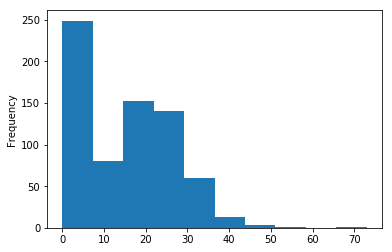

In [119]:
share_rprchs_prgrph_df.pred_proba.plot(kind = 'hist')
plt.show()

In [116]:
for i in range(len(share_rprchs_prgrph_df.pred_par[0:20])):
    print("=============",share_rprchs_prgrph_df.data_key_friendly_name[i],"=============")
    print("repurchase in par = ", 'repurchase' in share_rprchs_prgrph_df.pred_par[i])
    print(share_rprchs_prgrph_df.pred_par[i])
    print("")
    print("================================================================================")

============= Share Repurchase Intention =============
repurchase in par =  True
 ﻿ the revolving credit facility component of our june 2016 credit agreement provides borrowing capacity of $743 million and matures in december 2020. the maturity date will accelerate to october 2019 if, by that date, we have not amended, redeemed or refinanced at least $765 million of our senior notes due in january 2020. as of december 31, 2017, we have repurchased and refinanced approximately $758 million of our 4.05% senior notes due 2020. the revolving credit facility we entered into in december 2013, as reduced in june 2016, provides borrowing capacity of $66 million and matures in december 2018. as of december 31, 2017, there were no borrowings under either revolving credit facility; however, there was $323 million in letters of credit outstanding against the 2016 revolving credit facility. as of december 31, 2017, we were in compliance with all of the covenants of the term loan and revolving credi

In [124]:
share_rprchs_prgrph_df = share_rprchs_prgrph_df[share_rprchs_prgrph_df.pred_par != '']

In [125]:
share_rprchs_prgrph_df.reset_index(inplace=True, drop=True)

## initialize some storage columns for predicted text and pred_text validation metrics

In [120]:
share_rprchs_prgrph_df.columns

Index(['ticker', 'accession_number', 'data_key_friendly_name', 'pred_par',
       'pred_proba'],
      dtype='object')

In [121]:
share_rprchs_prgrph_df['pred_text'] = np.nan
share_rprchs_prgrph_df['predtext_proba'] = None
share_rprchs_prgrph_df['predtext_totinc'] = np.nan
share_rprchs_prgrph_df['predtext_inclpct'] = np.nan
share_rprchs_prgrph_df['predtext_bggpct'] = np.nan
share_rprchs_prgrph_df['testtext_totinc'] = np.nan
share_rprchs_prgrph_df['predtext_tknzdlen'] = np.nan
share_rprchs_prgrph_df['testtext_tknzdlen'] = np.nan

In [59]:
share_rprchs_prgrph_df.predtext_proba[0]

In [60]:
type(share_rprchs_prgrph_df.pred_text[0])

numpy.float64

In [61]:
np.nan == np.nan

False

## For each predicted paragraph/row
### predict and validate predicted text column with test text column

In [132]:
#for i in range(len(training_filings_list)):
for i in range(len(validation_filings_list)):
    #filing = training_filings_list[i]
    filing = validation_filings_list[i]
    ti = datetime.datetime.now()
    print(ti, 'WORKING ON FILING', i, 'out of', len(validation_filings_list), 100*i/len(validation_filings_list), '% done.')
    # filter down to that filings dataframe rows
    # extract the accesion number back out of the filing path
    #an = re.sub('data/nc_training_filings/', '', filing)
    an = re.sub('data/nc_validation_filings/', '', filing)
    an = re.sub('.html', '', an)
    
    # for each dkfn_row in df_slice
    for i in share_rprchs_prgrph_df.data_key_friendly_name[share_rprchs_prgrph_df.accession_number == an].index:
        to = datetime.datetime.now()
        print(to, '-- working on', share_rprchs_prgrph_df.ticker[i], share_rprchs_prgrph_df.data_key_friendly_name[i])
        
        # If there is already a prediction move on to the next row
        if share_rprchs_prgrph_df.predtext_proba[i] != None:
            print("---- already made a prediction for", share_rprchs_prgrph_df.ticker[i], share_rprchs_prgrph_df.data_key_friendly_name[i])
            continue
        
        # select appropriate dkfn key_tokens
        for k in dkfn_kts_dict.keys():
            # trim the name of the key
            trimmed_key = re.sub('_kts', '', k)
            # check to see if it is in the dkfn column.lower()
            if trimmed_key in share_rprchs_prgrph_df.data_key_friendly_name[i].lower():
                # for authorization, distinguish between generic auth and auth_date
                if trimmed_key == 'auth' and 'date' in share_rprchs_prgrph_df.data_key_friendly_name[i].lower():
                    continue
                # if so, then assign that kts df
                key_tokens = dkfn_kts_dict[k]
                print(datetime.datetime.now(), '------ using key_tokens for', k)
        
        #predict a text using that rows dkfn's margin and key toks
        nominees, par = define_nominated_texts(share_rprchs_prgrph_df.pred_par[i], key_tokens = key_tokens, margin = 6)
        
        # select appropriate model for dkfn
        for k in models_dict.keys():
            # trim the name of the key
            trimmed_key = re.sub('_model', '', k)
            # check to see if it is in the dkfn column.lower()
            if trimmed_key in share_rprchs_prgrph_df.data_key_friendly_name[i].lower():
                # for authorization, distinguish between generic auth and auth_date
                if trimmed_key == 'auth' and 'date' in share_rprchs_prgrph_df.data_key_friendly_name[i].lower():
                    continue
                # if so, then assign that kts df
                model = models_dict[k]
                print(datetime.datetime.now(), '------ using', k)
        
        #pred_par = par_with_highest_kt_hit_density or par_with_models_highest_pred_proba
        pred_dct = get_model_paragraph(nominees, par, model = model, key_tokens=key_tokens, vectorizer=tfidf_vectorizer, verbose = False, inverse= False)
        prd_txt = pred_dct['nominee']
        
        # write the paragraph to the df
        share_rprchs_prgrph_df.pred_text[i] = prd_txt
        share_rprchs_prgrph_df.predtext_proba[i] = pred_dct['best_proba']
        print(datetime.datetime.now(), '---------- wrote predicted paragraph. row took', datetime.datetime.now() - ti)
        #print('wrote', pred_par)
        
        # score the inclusion
        #results_dct = measure_inclusion(prd_txt, share_rprchs_prgrph_df.text[i], verbose = False)
        print(datetime.datetime.now(), "measured inclusion.")
        print("="*75)
        # store the inclusion data
        #share_rprchs_prgrph_df.predtext_totinc[i] = (results_dct['total_inclusion'])
        #share_rprchs_prgrph_df.predtext_inclpct[i] = (results_dct['inclusion_pct'])
        #share_rprchs_prgrph_df.predtext_bggpct[i] = (results_dct['baggage_pct'])
        #share_rprchs_prgrph_df.testtext_tknzdlen[i] = (results_dct['test_tokenized_par_len'])
        #share_rprchs_prgrph_df.predtext_tknzdlen[i] = (results_dct['pred_tokenized_par_len'])
        

2018-06-09 21:43:35.154943 WORKING ON FILING 0 out of 100 0.0 % done.
2018-06-09 21:43:35.157064 -- working on AWI Share Repurchase Intention
2018-06-09 21:43:35.157842 ------ using key_tokens for intent_kts
2018-06-09 21:43:35.158673 ------ using intent_model
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on


/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:914: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.loc[key] = value
/Users/paulomartinez/anaconda3

2018-06-09 21:43:35.877871 ---------- wrote predicted paragraph. row took 0:00:00.722934
2018-06-09 21:43:35.878157 measured inclusion.
2018-06-09 21:43:35.878224 -- working on AWI Share Repurchase Utilization
2018-06-09 21:43:35.878863 ------ using key_tokens for util_kts
2018-06-09 21:43:35.879747 ------ using util_model
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
2018-06-09 21:43:36.053009 ---------- wrote predicted paragraph. row took 0:00:00.898072
2018-06-09 21:

Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
2018-06-09 21:43:37.953368 ---------- wrote predicted paragraph. row took 0:00:00.496353
2018-06-09 21:43:37.953776 measured inclusion.
2018-06-09 21:43:37.954126 -- working on EAT Amount Spent on Share Repurchases
2018-06-09 21:43:37.955109 ------ using key_tokens for spent_kts
2018-06-09 21:43:37.955999 ------ using spent_model
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value er

Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
2018-06-09 21:43:39.781245 ---------- wrote predicted paragraph. row took 0:00:00.441783
2018-06-09 21:43:39.781429 measured inclusion.
2018-06-09 21:43:39.781579 -- working on DKS Amount Spent on Share Repurchases
2018-06-09 21:43:39.782771 ------ using key_tokens for spent_kts
2018-06-09 21:43:39.783569 ------ using spent_model
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
2018-06-09 21:43:39.998852 ---

2018-06-09 21:43:41.730503 ---------- wrote predicted paragraph. row took 0:00:00.787479
2018-06-09 21:43:41.730969 measured inclusion.
2018-06-09 21:43:41.731082 -- working on KBR Unknown Share Repurchase Data
2018-06-09 21:43:41.731482 ------ using key_tokens for unk_kts
2018-06-09 21:43:41.732724 ------ using unk_model
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
movi

2018-06-09 21:43:43.930084 ---------- wrote predicted paragraph. row took 0:00:00.729179
2018-06-09 21:43:43.949412 measured inclusion.
2018-06-09 21:43:43.977878 -- working on ENR Unknown Share Repurchase Data
2018-06-09 21:43:43.980894 ------ using key_tokens for unk_kts
2018-06-09 21:43:43.982149 ------ using unk_model
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
movi

2018-06-09 21:43:46.175071 ---------- wrote predicted paragraph. row took 0:00:00.558321
2018-06-09 21:43:46.184466 measured inclusion.
2018-06-09 21:43:46.184562 -- working on FII Share Repurchase Authorization Date
2018-06-09 21:43:46.184942 ------ using key_tokens for date_kts
2018-06-09 21:43:46.185597 ------ using date_model
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
2018-06-09 21:43:46.374317 ---------- wrote predicted paragraph. row took 0:00:00.757556
2018-06-09 21:43:46.374461 measured inclusion.
2018-06-09 21:43:46.374529 -- working on FII Unknown Share Repurchase Data
2018-06-09 21:43:46.374837 ------ using key_tokens for unk_kts
2018-06-09 21:43:46.375932 ------ using unk_model
Value error
moving on
Value error
mo

Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value erro

2018-06-09 21:43:50.439710 ---------- wrote predicted paragraph. row took 0:00:01.601919
2018-06-09 21:43:50.440005 measured inclusion.
2018-06-09 21:43:50.440118 WORKING ON FILING 13 out of 100 13.0 % done.
2018-06-09 21:43:50.472514 -- working on OFC Share Repurchase Authorization Date
2018-06-09 21:43:50.472913 ------ using key_tokens for date_kts
2018-06-09 21:43:50.473579 ------ using date_model
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
2018-06-09 21:43:50.681237 ---------- wrote predicted paragraph. row

Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
2018-06-09 21:43:53.209141 ---------- wrote predicted paragraph. row took 0:00:01.234888
2018-06-09 21:43:53.210549 measured inclusion.
2018-06-09 21:43:53.210721 -- working on AFSI Unknown Share Repurchase Data
2018-06-09 21:43:53.211256 ------ using key_tokens for unk_kts
2018-06-09 21:43:53.213034 ------ using unk_model
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
mov

moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
2018-06-09 21:43:55.894856 ---------- wrote predicted paragraph. row took 0:00:00.999383
2018-06-09 21:43:55.895130 measured inclusion.
2018-06-09 21:43:55.895273 -- working on MDRX Share Repurchase Authorization Date
2018-06-09 21:43:55.896049 ------ using key_tokens for date_kts
2018-06-09 21:43:55.897955 ------ using date_model
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
2018-06-09 21:43:56.110674 ---------- wrote predicted paragraph. row took 0:00:01.215200
2018-06-09 21:43:56.110953 measured inclusion.
2018-06-09 21:43:56.111061 -- working on MDRX Unknown Share Repurchase Data
2018-

Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
2018-06-09 21:43:58.373415 ---------- wrote predicted paragraph. row took 0:00:01.738744
2018-06-09 21:43:58.373706 measured inclusion.
2018-06-09 21:43:58.373824 WORKING ON FILING 20 out of 100 20.0 % done.
2018-06-09 21:43:58.381269 -- working on DDR Share Repurchase Authorization Date
2018-06-09 21:43:58.384331 ------ using key_tokens for date_kts
2018-06-09 21:43:58.385194 ------ using date_model
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Va

Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
2018-06-09 21:44:00.643281 ---------- wrote predicted paragraph. row took 0:00:01.441142
2018-06-09 21:44:00.643459 measured inclusion.
2018-06-09 21:44:00.643584 -- working on TPX Share Repurchase Authorization
2018-06-09 21:44:00.644108 ------ using key_tokens for auth_kts
2018-06-09 21:44:00.645086 ------ using auth_model
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
m

2018-06-09 21:44:02.671448 ---------- wrote predicted paragraph. row took 0:00:00.356329
2018-06-09 21:44:02.672202 measured inclusion.
2018-06-09 21:44:02.673269 -- working on AHL Share Repurchase Utilization
2018-06-09 21:44:02.673850 ------ using key_tokens for util_kts
2018-06-09 21:44:02.675297 ------ using util_model
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
2018-06-09 21:44:02.872782 ---------- wrote predicted paragraph. row took 0:00:00.557663
2018-06-09 21:44:02.872942 measured inclusion.
2018-06-09 21:44:02.872997 -- working on AHL Amount Spent on Share Repurchases
2018-06-09 21:44:02.873931 ------ using key_tokens for spent_kts
2018-06-09 21:44:02.874716 ------ using spent_model
Value error
m

Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
2018-06-09 21:44:04.985796 ---------- wrote predicted paragraph. row took 0:00:00.875429
2018-06-09 21:44:04.986084 measured inclusion.
2018-06-09 21:44:04.986193 -- working on TWO Share Repurchase Count
2018-06-09 21:44:04.986703 ------ using key_tokens for count_kts
2018-06-09 21:44:04.988596 ------ using count_model
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving 

2018-06-09 21:44:07.224269 ---------- wrote predicted paragraph. row took 0:00:00.215802
2018-06-09 21:44:07.225382 measured inclusion.
2018-06-09 21:44:07.225446 -- working on RPAI Share Repurchase Utilization
2018-06-09 21:44:07.225821 ------ using key_tokens for util_kts
2018-06-09 21:44:07.226910 ------ using util_model
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
2018-06-09 21:44:07.491538 ---------- wrote predicted paragraph. row took 0:00:00.483074
2018-06-09 21:44:07.491818 measured inclusion.
2018-06-09 21:44:07.491928 -- wo

Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
2018-06-09 21:44:09.930408 ---------- wrote predicted paragraph. row took 0:00:00.258577
2018-06-09 21:44:09.930737 measured inclusion.
2018-06-09 21:44:09.930852 -- working on PRA Share Repurchase Authorization Date
2018-06-09 21:44:09.931601 ------ using key_tokens for date_kts
2018-06-09 21:44:09.932584 ------ using date_model
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
2018-06-09 21:44:10.207450 ---------- wrote predicte

Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
2018-06-09 21:44:12.274431 ---------- wrote predicted paragraph. row took 0:00:00.206353
2018-06-09 21:44:12.274701 measured inclusion.
2018-06-09 21:44:12.274775 WORKING ON FILING 33 out of 100 33.0 % done.
2018-06-09 21:44:12.276119 -- working on FIT Share Repurchase Authorization Date
2018-06-09 21:44:12.276732 ------ using key_tokens for date_kts
2018-06-09 21:44:12.277508 ------ using date_model
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
2018-06-09 21:44:12.468068 ---------- wrote predicted paragraph. row took 0:00:00.193299
2

moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
2018-06-09 21:44:14.263900 ---------- wrote predicted paragraph. row took 0:00:00.198155
2018-06-09 21:44:14.264072 measured inclusion.
2018-06-09 21:44:14.264136 -- working on BBBY Share Repurchase Utilization
2018-06-09 21:44:14.264388 ------ using key_tokens for util_kts
2018-06-09 21:44:14.265267 ------ using util_model
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Valu

Value error
moving on
Value error
moving on
2018-06-09 21:44:15.829751 ---------- wrote predicted paragraph. row took 0:00:00.414184
2018-06-09 21:44:15.830097 measured inclusion.
2018-06-09 21:44:15.830229 -- working on LPNT Unknown Share Repurchase Data
2018-06-09 21:44:15.830585 ------ using key_tokens for unk_kts
2018-06-09 21:44:15.832050 ------ using unk_model
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
mov

Value error
moving on
Value error
moving on
2018-06-09 21:44:17.593225 ---------- wrote predicted paragraph. row took 0:00:00.272091
2018-06-09 21:44:17.593729 measured inclusion.
2018-06-09 21:44:17.593844 -- working on PBI Share Repurchase Count
2018-06-09 21:44:17.594331 ------ using key_tokens for count_kts
2018-06-09 21:44:17.595912 ------ using count_model
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
2018-06-09 21:44:17.851251 ---------- wrote predicted paragraph. row took 0:00:00.530115
2018-06-09 21:44:17.851401 measured inclusion.
2018-06-09 21:44:17.851479 -- working on PBI Share Repurchase Authorization Date
2018-06-09 21:44:17.85

moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
2018-06-09 21:44:20.383017 ---------- wrote predicted paragraph. row took 0:00:00.472357
2018-06-09 21:44:20.383173 measured inclusion.
2018-06-09 21:44:20.383258 -- working on INT Amount Spent on Share Repurchases
2018-06-09 21:44:20.383765 ------ using key_tokens for spent_kts
2018-06-09 21:44:20.384544 ------ using spent_model
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
2018-06-09 21:44:20.597377 ---------- wrote predicted paragraph. row took 0:00:00.686718
2018-06-09 21:44:20

2018-06-09 21:44:22.467110 ---------- wrote predicted paragraph. row took 0:00:00.759170
2018-06-09 21:44:22.467242 measured inclusion.
2018-06-09 21:44:22.467296 -- working on SBH Share Repurchase Count
2018-06-09 21:44:22.467681 ------ using key_tokens for count_kts
2018-06-09 21:44:22.468610 ------ using count_model
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving 

Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
2018-06-09 21:44:25.078593 ---------- wrote predicted paragraph. row took 0:00:00.242725
2018-06-09 21:44:25.078821 measured inclusion.
2018-06-09 21:44:25.078918 -- working on VMI Share Repurchase Utilization
2018-06-09 21:44:25.079276 ------ using key_tokens for util_kts
2018-06-09 21:44:25.080328 ------ using util_model
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
mov

2018-06-09 21:44:27.328994 ---------- wrote predicted paragraph. row took 0:00:00.911882
2018-06-09 21:44:27.329349 measured inclusion.
2018-06-09 21:44:27.329464 -- working on OI Unknown Share Repurchase Data
2018-06-09 21:44:27.329863 ------ using key_tokens for unk_kts
2018-06-09 21:44:27.331830 ------ using unk_model
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
2018-06-09 21:44:27.559774 ---------- wrote predicted paragraph. row took 0:00:01.1

Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
2018-06-09 21:44:29.760055 ---------- wrote predicted paragraph. row took 0:00:01.110940
2018-06-09 21:44:29.760210 measured inclusion.
2018-06-09 21:44:29.760272 WORKING ON FILING 48 out of 100 48.0 % done.
2018-06-09 21:44:29.762235 -- working on AMCX Share Repurchase Intention
2018-06-09 21:44:29.763641 ------ using key_tokens for intent_kts
2018-06-09 21:44:29.764554 ------ using intent_model
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value 

2018-06-09 21:44:31.665740 ---------- wrote predicted paragraph. row took 0:00:00.235010
2018-06-09 21:44:31.665894 measured inclusion.
2018-06-09 21:44:31.665950 -- working on XON Share Repurchase Authorization Date
2018-06-09 21:44:31.666446 ------ using key_tokens for date_kts
2018-06-09 21:44:31.667303 ------ using date_model
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
2018-06-09 21:44:31.854790 ---------- wrote predicted paragraph. row took 0:00:00.424061
2018-06-09 21:44:31.855736 measured inclusion.
2018-06-09 21:44:31.855837 WORKING ON FILING 51 out of 100 51.0 % done.
2018-06-09 21:44:31.857796 -- working on LM Share Repurchase Intention
2018-06-09 21:44:31.858374 ------ using key_tokens for intent_kts
2018-06-09 21:4

moving on
2018-06-09 21:44:34.449302 ---------- wrote predicted paragraph. row took 0:00:00.484110
2018-06-09 21:44:34.449473 measured inclusion.
2018-06-09 21:44:34.449528 -- working on BKD Share Repurchase Authorization Date
2018-06-09 21:44:34.450030 ------ using key_tokens for date_kts
2018-06-09 21:44:34.450950 ------ using date_model
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
2018-06-09 21:44:34.652866 ---------- wrote predicted paragraph. row took 0:00:00.687704
2018-06-09 21:44:34.653312 measured inclusion.
2018-06-09 21:44:34.653430 WORKING ON FILING 54 out of 100 54.0 % done.
2018-06-09 21:44:34.655902 -- wo

Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
2018-06-09 21:44:36.697766 ---------- wrote predicted paragraph. row took 0:00:00.919704
2018-06-09 21:44:36.698056 measured inclusion.
2018-06-09 21:44:36.698171 -- working on MNK Share Repurchase Authorization Date
2018-06-09 21:44:36.698735 ------ using key_tokens for date_kts
2018-06-09 21:44:36.699845 ------ using date_model
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value er

2018-06-09 21:44:38.260695 -- working on SLGN Unknown Share Repurchase Data
2018-06-09 21:44:38.293391 ------ using key_tokens for unk_kts
2018-06-09 21:44:38.294291 ------ using unk_model
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
2018-06-09 21:44:38.507539 ---------- wrote predicted paragraph. row took 0:00:01.114903
2018-06-09 21:44:38.507670 measured inclusion.
2018-06-09 21:44:38.507731 -- working on SLGN Share Repurchase Authorization
2018-06-09 21:44:38.508191 ------ using key_tokens for auth_kts
2018-06-09 21:44:38.509086 -

moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
2018-06-09 21:44:40.894060 ---------- wrote predicted paragraph. row took 0:00:01.530277
2018-06-09 21:44:40.894211 measured inclusion.
2018-06-09 21:44:40.894313 WORKING ON FILING 59 out of 100 59.0 % done.
2018-06-09 21:44:40.896253 -- working on SM Share Repurchase Intention
2018-06-09 21:44:40.897594 ------ using key_tokens for intent_kts
2018-06-09 21:44:40.898491 ------ using intent_model
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving o

Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
2018-06-09 21:44:44.318609 ---------- wrote predicted paragraph. row took 0:00:00.513555
2018-06-09 21:44:44.318928 measured inclusion.
2018-06-09 21:44:44.319046 WORKING ON FILING 63 out of 100 63.0 % done.
2018-06-09 21:44:44.321813 -- working on MUSA Share Repurchase Intention
2018-06-09 21:44:44.322431 ------ using key_tokens for intent_kts
2018-06-09 21:44:44.323256 ------ using intent_model
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value 

Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
2018-06-09 21:44:46.335512 ---------- wrote predicted paragraph. row took 0:00:00.665134
2018-06-09 21:44:46.335750 measured inclusion.
2018-06-09 21:44:46.335892 -- working on WCC Share Repurchase Authorization
2018-06-09 21:44:46.336543 ------ using key_tokens for auth_kts
2018-06-09 21:44:46.338040 ------ using auth_model
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
m

Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
2018-06-09 21:44:48.789340 ---------- wrote predicted paragraph. row took 0:00:00.535636
2018-06-09 21:44:48.789672 measured inclusion.
2018-06-09 21:44:48.789781 -- working on MRVL Share Repurchase Authorization Date
2018-06-09 21:44:48.790327 ------ using key_tokens for date_kts
2018-06-09 21:44:48.791395 ------ using date_model
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value e

Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
2018-06-09 21:44:50.991533 ---------- wrote predicted paragraph. row took 0:00:00.233700
2018-06-09 21:44:50.992163 measured inclusion.
2018-06-09 21:44:50.992257 -- working on PAY Share Repurchase Count
2018-06-09 21:44:50.992842 ------ using key_tokens for count_kts
2018-06-09 21:44:50.993949 ------ using count_model
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving 

Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
2018-06-09 21:44:52.858373 ---------- wrote predicted paragraph. row took 0:00:00.934741
2018-06-09 21:44:52.858520 measured inclusion.
2018-06-09 21:44:52.858595 -

moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
2018-06-09 21:44:54.660864 ---------- wrote predicted paragraph. row took 0:00:00.448901
2018-06-09 21:44:54.663468 measured inclusion.
2018-06-09 21:44:54.663895 -- working on WTM Amount Spent on Share Repurchases
2018-06-09 21:44:54.664411 ------ using key_tokens for spent_kts
2018-06-09 21:44:54.665410 ------ using spent_model
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving o

2018-06-09 21:44:56.884640 ---------- wrote predicted paragraph. row took 0:00:01.063115
2018-06-09 21:44:56.884793 measured inclusion.
2018-06-09 21:44:56.884867 -- working on NBR Unknown Share Repurchase Data
2018-06-09 21:44:56.885178 ------ using key_tokens for unk_kts
2018-06-09 21:44:56.886870 ------ using unk_model
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
movi

Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
2018-06-09 21:44:59.064583 ---------- wrote predicted paragraph. row took 0:00:01.721620
2018-06-09 21:44:59.064969 measured inclusion.
2018-06-09 21:44:59.065077 WORKING ON FILING 76 out of 100 76.0 % done.
2018-06-09 21:44:59.087518 -- working on SKT Share Repurchase Intention
2018-06-09 21:44:59.088541 ------ using key_tokens for intent_kts
2018-06-09 21:44:59.089493 ------ using intent_model
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value e

Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
2018-06-09 21:45:01.641306 ---------- wrote predicted paragraph. row took 0:00:00.239549
2018-06-09 21:45:01.641664 measured inclusion.
2018-06-09 21:45:01.641758 -- working on DRQ Share Repurchase Authorization Date
2018-06-09 21:45:01.642331 ------ using key_tokens for date_kts
2018-06-09 21:45:01.643457 ------ using date_model
Value er

Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
2018-06-09 21:45:03.830847 ---------- wrote predicted paragraph. row took 0:00:01.411612
2018-06-09 21:45:03.831057 measured inclusion.
2018-06-09 21:45:03.831171 -- working on EPC Share Repurchase Authorization
2018-06-09 21:45:03.831746 ------ using key_tokens for auth_kts
2018-06-09 21:45:03.832918 ------ using auth_model
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
m

moving on
2018-06-09 21:45:05.757944 ---------- wrote predicted paragraph. row took 0:00:00.460095
2018-06-09 21:45:05.758092 measured inclusion.
2018-06-09 21:45:05.758148 -- working on GHC Unknown Share Repurchase Data
2018-06-09 21:45:05.758483 ------ using key_tokens for unk_kts
2018-06-09 21:45:05.759578 ------ using unk_model
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
2018-06-09 21:45:05.972530 ---------- wrote predic

2018-06-09 21:45:07.835948 ---------- wrote predicted paragraph. row took 0:00:01.621506
2018-06-09 21:45:07.837227 measured inclusion.
2018-06-09 21:45:07.837311 WORKING ON FILING 83 out of 100 83.0 % done.
2018-06-09 21:45:07.839375 -- working on CMP Share Repurchase Authorization Date
2018-06-09 21:45:07.840690 ------ using key_tokens for date_kts
2018-06-09 21:45:07.841634 ------ using date_model
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
2018-06-09 21:45:08.064709 ---------- wrote predicted paragraph. row took 0:00:00.227405
2

Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
2018-06-09 21:45:10.422283 ---------- wrote predicted paragraph. row took 0:00:01.490073
2018-06-09 21:45:10.422645 measured inclusion.
2018-06-09 21:45:10.422779 -- working on RLGY Share Repurchase Authorization
2018-06-09 21:45:10.423413 ------ using key_tokens for auth_kts
2018-06-09 21:45:10.424679 ------ using auth_model
Value error
moving on
Value error
moving on
Value error
moving on
Value error


Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
2018-06-09 21:45:13.282858 ---------- wrote predicted paragraph. row took 0:00:00.444092
2018-06-09 21:45:13.283768 measured inclusion.
2018-06-09 21:45:13.283983 -- working on MFA Share Repurchase Authorization Date
2018-06-09 21:45:13.284699 ------ using key_tokens for date_kts
2018-06-09 21:45:13.286672 ------ using date_model
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value er

Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
2018-06-09 21:45:15.303184 ---------- wrote predicted paragraph. row took 0:00:01.041363
2018-06-09 21:45:15.303431 measured inclusion.
2018-06-09 21:45:15.303521 -- working on DDS Unknown Share Repurchase Data
2018-06-09 21:45:15.303870 ------ using key_tokens for unk_kts
2018-06-09 21:45:15.305131 ------ using unk_model
Value error
moving on
Value error
movi

Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
2018-06-09 21:45:17.332455 ---------- wrote predicted paragraph. row took 0:00:00.461986
2018-06-09 21:45:17.332845 measured inclusion.
2018-06-09 21:45:17.333161 -- working on RRD Share Repurchase Authorization Date
2018-06-09 21:45:17.333925 ------ using key_tokens for date_kts
2018-06-09 21:45:17.334833 ------ using date_model
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
2018-06-09 21:45:17.544250 ---------- wrote predicted paragraph. row took 0:00:00.673777
2018-06-09 21:45:17.544411 measured inclusion.
2018

Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
2018-06-09 21:45:19.326013 ---------- wrote predicted paragraph. row took 0:00:00.198155
2018-06-09 21:45:19.326374 measured inclusion.
2018-06-09 21:45:19.326455 -- working on CCO Share Repurchase Count
2018-06-09 21:45:19.326849 ------ using key_tokens for count_kts
2018-06-09 21:45:19.327781 ------ using count_model
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
2018-06-09 21:45:19.531898 ---------- wrote predicted paragraph

moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
2018-06-09 21:45:21.489245 ---------- wrote predicted paragraph. row took 0:00:01.592989
2018-06-09 21:45:21.489405 measured inclusion.
2018-06-09 21:45:21.489516 WORKING ON FILING 96 out of 100 96.0 % done.
2018-06-09 21:45:21.491465 -- working on TRCO Share Repurchase Intention
2018-06-09 21:45:21.492704 ------ using key_tokens for intent_kts
2018-06-09 21:45:21.493849 ------ using intent_model
Value error
moving on
Value error
moving

2018-06-09 21:45:23.599342 ------ using key_tokens for auth_kts
2018-06-09 21:45:23.601399 ------ using auth_model
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
2018-06-09 21:45:24.131482 ---------- wrote predicted paragraph. row to

2018-06-09 21:45:26.434613 ------ using date_model
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
Value error
moving on
2018-06-09 21:45:26.701365 ---------- wrote predicted paragraph. row took 0:00:00.774228
2018-06-09 21:45:26.701512 measured inclusion.
2018-06-09 21:45:26.701590 -- working on GME Unknown Share Repurchase Data
2018-06-09 21:45:26.701906 ------ using key_tokens for unk_kts
2018-06-09 21:45:26.702989 ------ using unk_model
Value error
moving on
Value error
moving on
Value err

In [135]:
set(share_rprchs_prgrph_df.pred_text)

{''}

share_rprchs_prgrph_df['pred_text'] = np.nan
share_rprchs_prgrph_df['predtext_proba'] = None
share_rprchs_prgrph_df['predtext_totinc'] = np.nan
share_rprchs_prgrph_df['predtext_inclpct'] = np.nan
share_rprchs_prgrph_df['predtext_bggpct'] = np.nan
share_rprchs_prgrph_df['testtext_totinc'] = np.nan
share_rprchs_prgrph_df['predtext_tknzdlen'] = np.nan
share_rprchs_prgrph_df['testtext_tknzdlen'] = np.nan

============================== Inclusion Report ==================================================
For each test text, how many of them are 100% included in the predicted text?
0.0 % total inclusion
------------------------------
For each test text, how much of it is included in the corresponding predicted text?


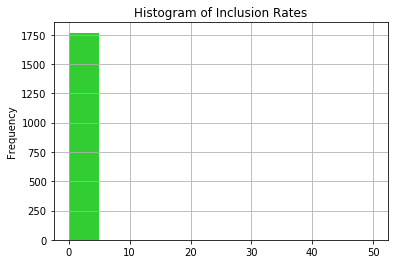

-- Mean inclusion rate 0.0753276836158192
-- Median inclusion rate 0.0
--------------------------

For each predicted text, how much of it is extra content not in the test paragraph?


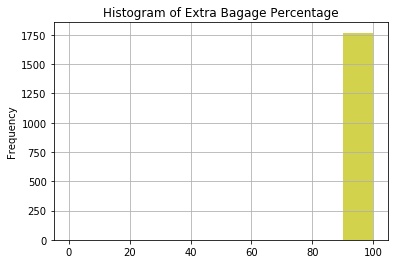

-- mean bagage rate:  99.90124153498871
-- median bagage rate:  100.0
----------------

What is the distribution of lengths of the word tokenized test texts.


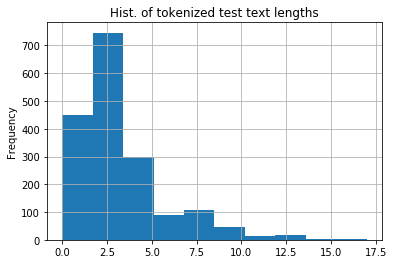

-- Mean tokenized test length  3.3188487584650113
-- Median tokenized test length 3.0
-- Range of tokenized test lengths 17.0
------------------------------

What is the distribution of lengths of the word tokenized test texts.


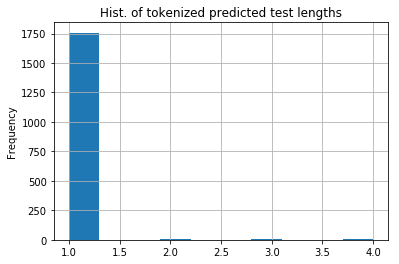

-- mean tokenized predicted text lenghts 1.0146726862302482
-- median tokenized predicted text lenghts 1.0
-- range of tokenized predicted text lenghts 3.0
------------------------------



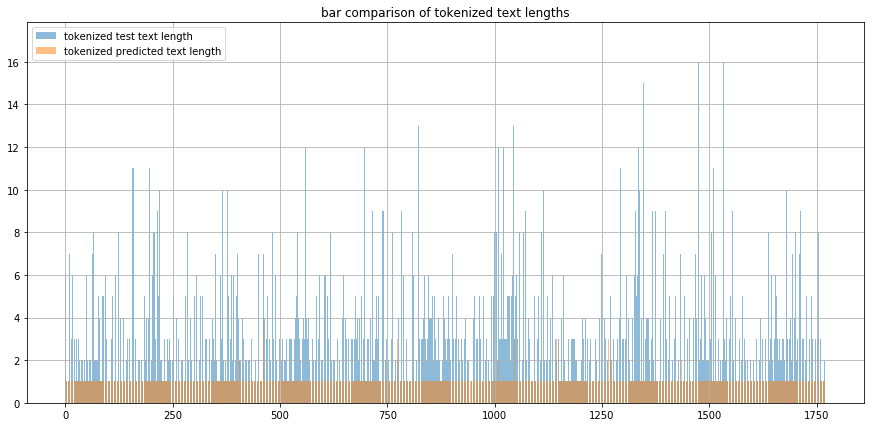

In [63]:
# report and plot the overall inclusion
print('='*30, 'Inclusion Report', '='*50)

# total inclusion rate
print("For each test text, how many of them are 100% included in the predicted text?")
print(round(100*(share_rprchs_prgrph_df.predtext_totinc.sum())/len(share_rprchs_prgrph_df.predtext_totinc), 2), '% total inclusion')
print("-"*30)

# report inclusion_rate
print('For each test text, how much of it is included in the corresponding predicted text?')
share_rprchs_prgrph_df.predtext_inclpct.plot(kind = 'hist', color = 'limegreen', alpha = 1)
plt.title('Histogram of Inclusion Rates')
plt.grid()
plt.show()
print('-- Mean inclusion rate', np.mean(share_rprchs_prgrph_df.predtext_inclpct))
print('-- Median inclusion rate', share_rprchs_prgrph_df.predtext_inclpct.median())
print("--------------------------")
print("")

# report extra baggage rate
print('For each predicted text, how much of it is extra content not in the test paragraph?')
share_rprchs_prgrph_df.predtext_bggpct.plot(kind = 'hist', color = 'y', alpha = .7)
plt.title('Histogram of Extra Bagage Percentage')
plt.grid()
plt.show()
print('-- mean bagage rate: ', np.mean(share_rprchs_prgrph_df.predtext_bggpct))
print('-- median bagage rate: ', share_rprchs_prgrph_df.predtext_bggpct.median())
print("----------------")
print("")

# report lengths of tokenized test strings
print("What is the distribution of lengths of the word tokenized test texts.")
share_rprchs_prgrph_df.testtext_tknzdlen.plot(kind = 'hist')
plt.title('Hist. of tokenized test text lengths')
plt.grid()
plt.show()
print('-- Mean tokenized test length ', np.mean(share_rprchs_prgrph_df.testtext_tknzdlen))
print('-- Median tokenized test length', share_rprchs_prgrph_df.testtext_tknzdlen.median())
print('-- Range of tokenized test lengths', np.max(share_rprchs_prgrph_df.testtext_tknzdlen) - np.min(share_rprchs_prgrph_df.testtext_tknzdlen))
print("-"*30)
print("")

# report lengths of tokenized predicted strings
print("What is the distribution of lengths of the word tokenized test texts.")
share_rprchs_prgrph_df.predtext_tknzdlen.plot(kind = 'hist')
plt.title('Hist. of tokenized predicted test lengths')
plt.grid()
plt.show()
print('-- mean tokenized predicted text lenghts', np.mean(share_rprchs_prgrph_df.predtext_tknzdlen))
print('-- median tokenized predicted text lenghts', share_rprchs_prgrph_df.predtext_tknzdlen.median())
print('-- range of tokenized predicted text lenghts', (np.max(share_rprchs_prgrph_df.predtext_tknzdlen)) - np.min(share_rprchs_prgrph_df.predtext_tknzdlen))
print("-"*30)
print("")
# plot overlay of each string's lengths
plt.figure(figsize = (15,7))
plt.bar(height = share_rprchs_prgrph_df.testtext_tknzdlen.fillna(np.nan), alpha = 0.5,
        x = range(len(share_rprchs_prgrph_df.text)))
plt.bar(height = share_rprchs_prgrph_df.predtext_tknzdlen.fillna(np.nan), alpha = 0.5,
        x = range(len(share_rprchs_prgrph_df.text)))
plt.title('bar comparison of tokenized text lengths')
plt.legend(['tokenized test text length', 'tokenized predicted text length'])
plt.grid()
plt.show()

## examine output

In [64]:
share_rprchs_prgrph_df.head(3)

,ticker,accession_number,data_key_friendly_name,text,data_value,reported_data_value,reported_units,paragraph_text,pred_par,amount,...,baggage_pct,tknzd_pred_par_len,pred_text,predtext_proba,predtext_totinc,predtext_inclpct,predtext_bggpct,testtext_totinc,predtext_tknzdlen,testtext_tknzdlen
0,A,0001090872-17-000018,Share Repurchase Authorization Date,"May 28, 2015",20150528,20200000.00,ones,"On May 28, 2015 we announced that our board ...","ases under this authorization. on may 28, 2015...",0,...,40.00,110,,0,False,0.0,100.0,NaN,1.0,3.0
1,A,0001090872-17-000018,Share Repurchase Authorization,The 2015 share repurchase program authorizes t...,1140000000,1.14,billions,"On May 28, 2015 we announced that our board ...","31, 2016 we repurchased approximately 2.4 mil...",0,...,40.91,110,,0,False,0.0,100.0,NaN,1.0,6.0
2,A,0001090872-17-000018,Share Repurchase Intention,remaining authorization to repurchase up to,610000000,610.00,millions,"Table of Contents 2016, upon the completion ...","zation. on may 28, 2015 we announced that our ...",0,...,47.27,110,,0,False,0.0,100.0,NaN,1.0,3.0


In [65]:
for i in range(len(share_rprchs_prgrph_df[0:20])):
    print('='*30, 'Compare test to predicted text', '='*30)
    print("DKFN:", share_rprchs_prgrph_df.data_key_friendly_name[i])
    print('-- Test Text:', share_rprchs_prgrph_df.text[i])
    print('  ', ". "*30)
    print('-- Pred Text:', share_rprchs_prgrph_df.pred_text[i])
    print('-'*60)

============================== Compare test to predicted text ==============================
DKFN: Share Repurchase Authorization Date
-- Test Text: May 28, 2015
   . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
-- Pred Text: 
------------------------------------------------------------
============================== Compare test to predicted text ==============================
DKFN: Share Repurchase Authorization
-- Test Text: The 2015 share repurchase program authorizes the purchase of up to
   . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
-- Pred Text: 
------------------------------------------------------------
============================== Compare test to predicted text ==============================
DKFN: Share Repurchase Intention
-- Test Text: remaining authorization to repurchase up to
   . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
-- Pred Text: 
------------------------------------------------------------
=======================

Share Repurchase Authorization
For each test text, how many of them are 100% included in the predicted text?
0.0 % total inclusion
------------------------------
For each test text, how much of it is included in the corresponding predicted text?


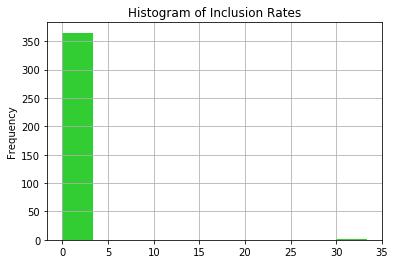

-- Mean inclusion rate 0.09106557377049179
-- Median inclusion rate 0.0
--------------------------

Share Repurchase Intention
For each test text, how many of them are 100% included in the predicted text?
0.0 % total inclusion
------------------------------
For each test text, how much of it is included in the corresponding predicted text?


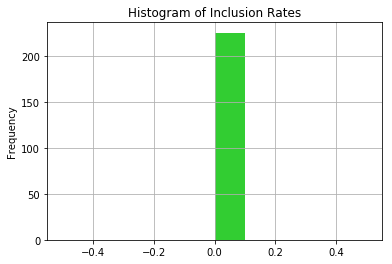

-- Mean inclusion rate 0.0
-- Median inclusion rate 0.0
--------------------------

Share Repurchase Count
For each test text, how many of them are 100% included in the predicted text?
0.0 % total inclusion
------------------------------
For each test text, how much of it is included in the corresponding predicted text?


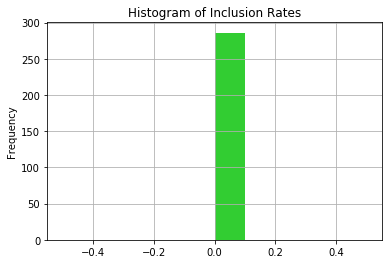

-- Mean inclusion rate 0.0
-- Median inclusion rate 0.0
--------------------------

Amount Spent on Share Repurchases
For each test text, how many of them are 100% included in the predicted text?
0.0 % total inclusion
------------------------------
For each test text, how much of it is included in the corresponding predicted text?


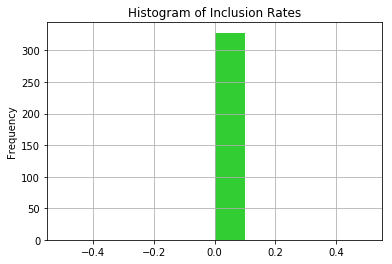

-- Mean inclusion rate 0.0
-- Median inclusion rate 0.0
--------------------------

Unknown Share Repurchase Data
For each test text, how many of them are 100% included in the predicted text?
0.0 % total inclusion
------------------------------
For each test text, how much of it is included in the corresponding predicted text?


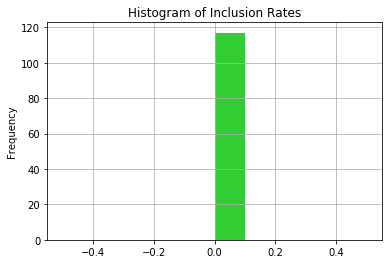

-- Mean inclusion rate 0.0
-- Median inclusion rate 0.0
--------------------------

Share Repurchase Utilization
For each test text, how many of them are 100% included in the predicted text?
0.0 % total inclusion
------------------------------
For each test text, how much of it is included in the corresponding predicted text?


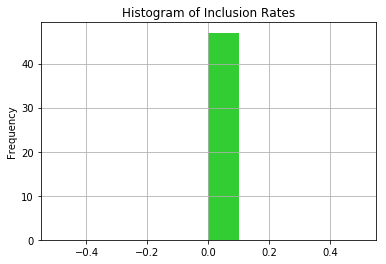

-- Mean inclusion rate 0.0
-- Median inclusion rate 0.0
--------------------------

Share Repurchase Authorization Date
For each test text, how many of them are 100% included in the predicted text?
0.0 % total inclusion
------------------------------
For each test text, how much of it is included in the corresponding predicted text?


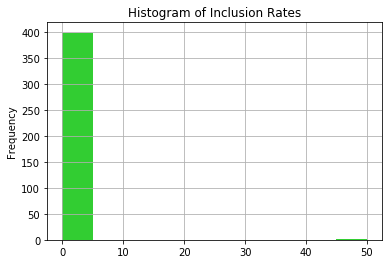

-- Mean inclusion rate 0.24937655860349128
-- Median inclusion rate 0.0
--------------------------



In [66]:
# look at the inclusion rates by dkfn
for dkfn in list(set(share_rprchs_prgrph_df.data_key_friendly_name)):
    print("=======================================")
    print(dkfn)
    print("=======================================")
    report_inclusion(share_rprchs_prgrph_df[share_rprchs_prgrph_df.data_key_friendly_name == dkfn])

## write out the csv

In [67]:
#share_rprchs_prgrph_df.to_csv

In [68]:
assert True == False

AssertionError: 

## test components above

In [ ]:
get_tfidf_ML_paragraph(nominees, string_filing, verbose = False, inverse= True)

## test tfidf vectorizer predictions

In [ ]:
for filing in training_filings_list[0:10]:
    '''# read in an html
    with open(filing) as file:
          file_html = file.read()
    # parse html
    parsed_html = BeautifulSoup(file_html)
    # filter out the html head, css, and cast to lower case
    string_filing = parsed_html.body.text.lower()'''
    
    
    nom_pars, string_filing = define_nominated_paragraphs(filing, dkfn_kts_dict['auth_kts'], margin)
    #nom_pars[0:5]
    
    
    
    nominee = ''
    best_proba = 0.0
    for tpl in nom_pars:
        # generate par
        par = string_filing[tpl[0]:tpl[1]]
        # pre process par
        par = re.sub(r'\n+', ' ', par)
        par = re.sub(r'\s+', ' ', par)
        # tfidf_vectorize the string into a sparse matrix
        par_tfidf_vectorized = tfidf_vectorizer.transform([par])
        # if the naiver bayes prediction of classification as a given dkfn's class is new_best probability
        if nb_auth_classifier.predict(par_tfidf_vectorized)[0] == 1 and nb_auth_classifier.predict_proba(par_tfidf_vectorized)[0][1] > best_proba:
            #print(nb_auth_classifier.predict_proba(par_tfidf_vectorized))
            nominee = par
            #print(nominee)
            best_proba = nb_auth_classifier.predict_proba(par_tfidf_vectorized)[0][1]
    
    print('best probability', best_proba)
    print('-'*100)
    print(nominee)
    print('='*100)

My Results are rather bad, based on visual inspection. 
- I have a feeling this is because the tfidf vectorizer is penalizing paragraphs that have precisely those terms that are most common in the training data. 
    - Well, all I know is that tfidf assigns low scores to terms that are super frequent across documents
        - i.e. 'authorized'
    - And it assigns high scores to terms that are frequent across documents
    - the result is that if 'authorized' appeard only once in each paragraph cell it would be scored very high
        - but the more it appears in each cell the more it gets penalized
- Then naive bayes is doing something (i know not what) to the effect of:
    - given that your paragraph has 'authorized' in it, how likely is it to be an authorization dkfn, as opposed to not. 
        - since all of or most of them have 'authorized' in there it probably thinks this term is rather irrelevant. 
        
 The problem is that my models are optimized to distinguish between relevant paragraphs, and to classify them based on their minor differences.
 - so it rewards paragraphs that have terms that are very rare in the training paragraphs
 - it's optimized to "split" hairs between good paragraphs, so it's trying to get as far away as possible from the "average" good paragraph, while still having "a toe" in the domain of their key tokens. 
 
If the model had been fit on noise and signal, it would be good at identifying noise. But since it was fit on signals 1 - 7, it is biased towards picking noise that is as unsimilar as possible to signals 1-7.

I, think... 🤔 

If my hypothesis is correct, then a count vectroizer should reward paragraphs that are most similar to training paragraphs
        

# Let's try out the results with a count vectorizer

In [ ]:
count_vectorizer = CountVectorizer(stop_words='english')
count_train = count_vectorizer.fit_transform(X_train)
count_test = count_vectorizer.transform(X_test)
second_nb_classifier = MultinomialNB()


In [ ]:
## Try out count vectorizer on 'authorization'
y_train = share_rprchs_prgrph_df.authorization[[ix in y_train_ix for ix in share_rprchs_prgrph_df.index]]

In [ ]:
y_test = share_rprchs_prgrph_df.authorization[[ix in y_test_ix for ix in share_rprchs_prgrph_df.index]]

In [ ]:
second_nb_classifier.fit(count_train, y_train)

In [ ]:
count_predictions = second_nb_classifier.predict(count_test)
metrics.accuracy_score(y_test, count_predictions)

In [ ]:
for filing in training_filings_list[0:10]:
    # read in an html
    with open(filing) as file:
          file_html = file.read()
    # parse html
    parsed_html = BeautifulSoup(file_html)
    # filter out the html head, css, and cast to lower case
    string_filing = parsed_html.body.text.lower()
    
    
    
    nom_pars = define_nominated_paragraphs(filing, dkfn_kts_dict['auth_kts'], margin)
    #nom_pars[0:5]
    
    
    
    nominee = ''
    best_proba = 0.0
    for tpl in nom_pars:
        # generate par
        par = string_filing[tpl[0]:tpl[1]]
        # pre process par
        par = re.sub(r'\n+', ' ', par)
        par = re.sub(r'\s+', ' ', par)
        
        # tfidf_vectorize the string into a sparse matrix
        #par_tfidf_vectorized = tfidf_vectorizer.transform([par])
        
        # count_vectorize the string into a sparse matrix
        vectorized_par = count_vectorizer.transform([par])
        
        # if the naiver bayes prediction of classification as a given dkfn's class is new_best probability
        if second_nb_classifier.predict(vectorized_par)[0] == 1 and second_nb_classifier.predict_proba(vectorized_par)[0][1] > best_proba:
            #print(nb_auth_classifier.predict_proba(par_tfidf_vectorized))
            nominee = par
            #print(nominee)
            best_proba = second_nb_classifier.predict_proba(vectorized_par)[0][1]
    
    print('best probability', best_proba)
    print('-'*100)
    print(nominee)
    print('='*100)

Again, the problem is that the model is optimized to reward the hairsplit differences between 7 signals. 
- so since 'authorization' appears in most of the 7 signals, it's relevance is ignored or downplayed
- whereas if 'further' appears more often in authorization signal than in the others, then it's going to pick noise paragraphs that have a hig count of the term 'further'

# 😜 if my models are so good at being bad, then what if I use the opposite of their prediction?

Ok, well let's try it for the count vectorizer. 
- although, I guess the key toks would get us in the "weather system"
- but the inverse count vecotrized prediction would reward the terms that were frequent across all of a dkfn's 'authorization' training paragraphs...

This did not work well for the inverse count prediction. I got 0/10 hits on 'authorized'

Try it again with the prediction being true, but then select the one with the lowes probability of being true. 
- no hits on 'authorized'
- 1/10 for 'repurchased'

😂 that worked for 5/10 with the tfidf on 'authorized'
- got 11/20 for 'authorized' with the inverse tfidf = 55%
- got 25/40 for 'authorized' with the inverse tfidf = 62.5%

So what is going on?
- if we think of each dkfn's paragraph cluster as a 'weather system' then the densest clouds represent the overlap, the commonalities between all that dkfn's paragraphs. all of that signals commonalities
- the tk_hits defines the 'weather system' 
- the tfidf rewards the 'edgiest' of the points, the outlier signals.
- the inverse tfidf rewards not what the dkfn paragraphs have in common, but rather what they have in common with the other signals. 
    - so it does a good job of getting us into the overlap between the signlas, it sort of defines the generica 'mean' signal. But it is not equipped to distinguish between noise and a given signal. 
    - it is only equipped to discern between the 7 signals. 
    
analogy:
- if i trained three models for classifying three instruments
    - rough electric guitar
        - the guitar model would determine that what stood out most about the electric guitar was it's low end growl and distortion
    - flute
       - the flute model would reward the sound of blowing
    - and drums
        - the drum model would reward percussion
- all three models would consider, rythm, and melody irrelevant (because all three instruments have those features).
- when 'released into the wild' 
    - the guitar model would prefer a diesel engine to an actual electric guitar
    - the flute model would prefer a tornado instead of any wind instrument
    - the drum model would prefer a jackhammer or construction zone over any percussion instrument
- the models would go out of their way to pass over instruments.


In [ ]:
for filing in training_filings_list[0:40]:
    # read in an html
    with open(filing) as file:
          file_html = file.read()
    # parse html
    parsed_html = BeautifulSoup(file_html)
    # filter out the html head, css, and cast to lower case
    string_filing = parsed_html.body.text.lower()
    
    
    
    nom_pars = define_nominated_paragraphs(filing, dkfn_kts_dict['auth_kts'], margin)
    #nom_pars[0:5]
    
    
    
    nominee = ''
    best_proba = 0.0
    for tpl in nom_pars:
        # generate par
        par = string_filing[tpl[0]:tpl[1]]
        # pre process par
        par = re.sub(r'\n+', ' ', par)
        par = re.sub(r'\s+', ' ', par)
        # tfidf_vectorize the string into a sparse matrix
        par_tfidf_vectorized = tfidf_vectorizer.transform([par])
        # if the naiver bayes prediction of classification as a given dkfn's class is new_best probability
        if nb_auth_classifier.predict(par_tfidf_vectorized)[0] == 0 and nb_auth_classifier.predict_proba(par_tfidf_vectorized)[0][0] > best_proba:
            #print(nb_auth_classifier.predict_proba(par_tfidf_vectorized))
            nominee = par
            #print(nominee)
            best_proba = nb_auth_classifier.predict_proba(par_tfidf_vectorized)[0][0]
    
    print('best probability', best_proba)
    print('-'*100)
    print(nominee)
    print('='*100)

In [137]:
# look at submission
submission = pd.read_csv('data/verbing_tigers_predicted_paragraphs1.csv', index_col=0)

,ticker,accession_number,data_key_friendly_name,pred_par,pred_proba
0,SWN,0000007332-18-000016,Share Repurchase Intention,﻿ the revolving credit facility component of ...,13.0
1,SWN,0000007332-18-000016,Share Repurchase Utilization,NaN,0.0
2,SWN,0000007332-18-000016,Amount Spent on Share Repurchases,NaN,0.0
3,SWN,0000007332-18-000016,Share Repurchase Count,NaN,0.0
4,SWN,0000007332-18-000016,Share Repurchase Authorization Date,interest expense related to our senior notes ...,23.0
5,SWN,0000007332-18-000016,Unknown Share Repurchase Data,NaN,0.0
6,SWN,0000007332-18-000016,Share Repurchase Authorization,NaN,0.0
7,FTR,0000020520-18-000007,Share Repurchase Intention,NaN,0.0
8,FTR,0000020520-18-000007,Share Repurchase Utilization,NaN,0.0
9,FTR,0000020520-18-000007,Amount Spent on Share Repurchases,NaN,0.0
